<a id='title'></a> 
# Описание проекта "Восстановление золота из золотосодержащей руды".

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Метрикой проекта будет sMAPE.

Работу над проектом будем проводить по следующему плану:

### Этап 1. Подготовка данных:

<a href='#1.1'>1.1. Импорт библиотек, чтение и изучение данных.</a> 

<a href='#1.2'>1.2. Проверка корректности расчёта эффективности обогащения.</a> 

<a href='#1.3'>1.3. Анализ разницы в признаках.</a> 

<a href='#1.4'>1.4. Преобработка данных.</a> 

### Этап 2. Анализ данных:

<a href='#2.1'>2.1. Исследование изменчивости концентрации металлов на различных этапах очистки.</a> 

<a href='#2.1'>2.1. Поиск аномальных значений в суммарной концентрации всех веществ на различных этапах обработки.</a> 

<a href='#2.1'>2.1. Исследование различий распределения размеров гранул сырья на обучающей и тестовой выборках.</a>  

### Этап 3. Моделирование:

<a href='#3.1'>3.1. Написание функции для вычисления итоговой sMAPE.</a> 

<a href='#3.2'>3.2. Подбор гиперпараметорв, моделирование, проверка моделей на адекватность.</a> 

# Этап 1. Подготовка данных.

<a id='1.1'></a> 
## Этап 1.1. Импорт библиотек, чтение и изучение данных.

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals.joblib import parallel_backend

Считаем набор данных. В условии сказано, что объекты в наборе данных индексируются датой (поле date). Передадим это поле как аргумент параметра index_col.

In [2]:
train = pd.read_csv('gold_recovery_train.csv', index_col='date')

Посмотрим на набор данных.

Для этого напишем функцию, которая будет принимать на вход набор данных и отображать информацию о нём: первые 10 строк набора данных, типы содержащихся в нём данных, его размер, наличие пропусков и дубликатов, а также уникальные значения в каждом из полей.

In [3]:
def df_info(df):
    print('Первые 10 строк DF')
    display(df.head(10))
    print('Общая информация о DF')
    display(df.info())
    print('Размер df:', df.shape)
    print()
    print('Пропуски в df')
    display(df.isna().sum())
    print('Количество дубликатов в df:', df.duplicated().sum())
    print()
    for col in df.columns:
        print('*** Поле', col + ': уникальные значения ***')
        display(df[col].value_counts())

In [4]:
df_info(train)

Первые 10 строк DF


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


Общая информация о DF
<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au       

None

Размер df: (16860, 86)

Пропуски в df


final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

Количество дубликатов в df: 16

*** Поле final.output.concentrate_ag: уникальные значения ***


0.000000    1263
0.010000     398
4.221066      19
5.925380      11
3.554558       8
            ... 
5.512879       1
4.821435       1
5.366093       1
5.098683       1
5.964677       1
Name: final.output.concentrate_ag, Length: 15080, dtype: int64

*** Поле final.output.concentrate_pb: уникальные значения ***


0.000000     1263
0.010000      398
12.014648      20
14.764648      11
12.202148       8
             ... 
10.597125       1
11.322756       1
9.771601        1
9.324238        1
10.738588       1
Name: final.output.concentrate_pb, Length: 15060, dtype: int64

*** Поле final.output.concentrate_sol: уникальные значения ***


0.000000     1263
0.010000      398
6.163379       19
6.663574       11
13.827148       8
             ... 
6.126598        1
8.613087        1
7.814677        1
10.269834       1
11.462742       1
Name: final.output.concentrate_sol, Length: 14778, dtype: int64

*** Поле final.output.concentrate_au: уникальные значения ***


0.000000     1263
0.010000      398
42.417690      19
37.336849      11
44.528214       8
             ... 
44.218390       1
44.100914       1
40.834250       1
44.515789       1
48.495295       1
Name: final.output.concentrate_au, Length: 15081, dtype: int64

*** Поле final.output.recovery: уникальные значения ***


100.000000    473
0.000000       89
67.275195       5
75.962757       5
74.832364       4
             ... 
70.333375       1
64.242529       1
74.111496       1
73.774982       1
63.355675       1
Name: final.output.recovery, Length: 14766, dtype: int64

*** Поле final.output.tail_ag: уникальные значения ***


0.000000     1658
7.958822        8
9.496956        5
11.881766       4
10.441984       3
             ... 
9.800471        1
11.978102       1
8.640743        1
6.716908        1
11.511670       1
Name: final.output.tail_ag, Length: 15119, dtype: int64

*** Поле final.output.tail_pb: уникальные значения ***


0.000000    1658
4.226074       8
2.034912       5
3.019287       4
4.413574       3
            ... 
1.661097       1
1.841531       1
3.565216       1
3.326900       1
3.557064       1
Name: final.output.tail_pb, Length: 15002, dtype: int64

*** Поле final.output.tail_sol: уникальные значения ***


0.000000     1658
9.827148        8
8.264648        5
9.452148        4
8.889648        3
             ... 
12.314943       1
11.318747       1
9.935425        1
10.894279       1
9.420944        1
Name: final.output.tail_sol, Length: 15040, dtype: int64

*** Поле final.output.tail_au: уникальные значения ***


0.000000    1658
3.199278       8
2.053974       5
3.386805       4
2.015914       3
            ... 
4.737289       1
2.551692       1
4.899260       1
3.211579       1
2.705088       1
Name: final.output.tail_au, Length: 15119, dtype: int64

*** Поле primary_cleaner.input.sulfate: уникальные значения ***


221.312399    1
129.502577    1
27.807915     1
133.520204    1
144.492385    1
             ..
114.467659    1
147.640904    1
65.814785     1
167.339015    1
128.624590    1
Name: primary_cleaner.input.sulfate, Length: 15553, dtype: int64

*** Поле primary_cleaner.input.depressant: уникальные значения ***


0.000000     57
40.000000     2
0.001873      2
14.036956     1
5.987640      1
             ..
15.001949     1
4.695373      1
5.893004      1
6.036891      1
6.948598      1
Name: primary_cleaner.input.depressant, Length: 15540, dtype: int64

*** Поле primary_cleaner.input.feed_size: уникальные значения ***


7.700000    388
7.250000    362
6.800000    307
7.300000    278
7.310000    258
           ... 
7.950000      1
8.150000      1
8.069999      1
7.480000      1
8.226833      1
Name: primary_cleaner.input.feed_size, Length: 3936, dtype: int64

*** Поле primary_cleaner.input.xanthate: уникальные значения ***


1.212362    1
1.611752    1
0.008996    1
0.990448    1
0.784123    1
           ..
0.886936    1
1.085831    1
0.866980    1
0.881458    1
0.805026    1
Name: primary_cleaner.input.xanthate, Length: 15875, dtype: int64

*** Поле primary_cleaner.output.concentrate_ag: уникальные значения ***


0.000000     1230
0.010000      523
9.987871        5
7.925334        5
10.073579       4
             ... 
6.860494        1
8.080138        1
10.292337       1
2.338969        1
6.710575        1
Name: primary_cleaner.output.concentrate_ag, Length: 15014, dtype: int64

*** Поле primary_cleaner.output.concentrate_pb: уникальные значения ***


0.000000     1230
0.010000      523
10.952148       6
9.014648        5
8.014648        4
             ... 
9.992970        1
6.217534        1
9.876658        1
8.554013        1
8.502417        1
Name: primary_cleaner.output.concentrate_pb, Length: 14730, dtype: int64

*** Поле primary_cleaner.output.concentrate_sol: уникальные значения ***


0.000000     1230
0.010000      523
9.014648        5
10.389648       5
10.577148       5
             ... 
14.931404       1
1.607508        1
8.254793        1
5.062986        1
13.714387       1
Name: primary_cleaner.output.concentrate_sol, Length: 14457, dtype: int64

*** Поле primary_cleaner.output.concentrate_au: уникальные значения ***


0.000000     1230
0.010000      523
36.306431       5
27.765463       5
31.280987       4
             ... 
15.885123       1
33.308930       1
33.620737       1
16.742278       1
36.887361       1
Name: primary_cleaner.output.concentrate_au, Length: 15011, dtype: int64

*** Поле primary_cleaner.output.tail_ag: уникальные значения ***


0.000000     1549
7.777319       11
22.302301      11
18.671520       5
15.964922       4
             ... 
16.221292       1
14.422418       1
17.253257       1
20.299647       1
11.275813       1
Name: primary_cleaner.output.tail_ag, Length: 15198, dtype: int64

*** Поле primary_cleaner.output.tail_pb: уникальные значения ***


0.000000    1549
6.663574      11
0.887634      11
4.257324       5
2.816162       4
            ... 
2.063308       1
3.317379       1
3.763205       1
5.182626       1
3.317946       1
Name: primary_cleaner.output.tail_pb, Length: 15182, dtype: int64

*** Поле primary_cleaner.output.tail_sol: уникальные значения ***


0.000000     1549
11.514648      11
1.572144       11
5.726074        5
9.077148        4
             ... 
8.693115        1
10.521785       1
9.255107        1
7.556967        1
6.451986        1
Name: primary_cleaner.output.tail_sol, Length: 15000, dtype: int64

*** Поле primary_cleaner.output.tail_au: уникальные значения ***


0.000000    1549
6.367418      11
9.657597      11
2.500740       5
3.478651       4
            ... 
2.586464       1
3.771066       1
2.159657       1
4.898916       1
6.171459       1
Name: primary_cleaner.output.tail_au, Length: 15198, dtype: int64

*** Поле primary_cleaner.state.floatbank8_a_air: уникальные значения ***


0.000000e+00    256
3.130442e-21    101
9.487558e-22     97
9.283186e-17     77
7.123791e-17     58
               ... 
1.598020e+03      1
1.766355e+03      1
1.701357e+03      1
1.449936e+03      1
1.647909e+03      1
Name: primary_cleaner.state.floatbank8_a_air, Length: 16079, dtype: int64

*** Поле primary_cleaner.state.floatbank8_a_level: уникальные значения ***


-773.734863    2
-350.626346    1
-499.972952    1
-500.197919    1
-500.310607    1
              ..
-500.114801    1
-500.332220    1
-498.866973    1
-499.564764    1
-499.435699    1
Name: primary_cleaner.state.floatbank8_a_level, Length: 16826, dtype: int64

*** Поле primary_cleaner.state.floatbank8_b_air: уникальные значения ***


0.000000e+00    257
5.503444e-21    101
7.179447e-17     77
9.257309e-17     58
1.000194e-16     35
               ... 
1.701221e+03      1
1.751408e+03      1
1.598555e+03      1
1.698779e+03      1
1.680887e+03      1
Name: primary_cleaner.state.floatbank8_b_air, Length: 16168, dtype: int64

*** Поле primary_cleaner.state.floatbank8_b_level: уникальные значения ***


-800.021118    6
-799.996521    2
-400.637420    1
-499.778515    1
-499.992762    1
              ..
-499.611119    1
-499.250029    1
-499.743873    1
-499.802820    1
-400.424794    1
Name: primary_cleaner.state.floatbank8_b_level, Length: 16827, dtype: int64

*** Поле primary_cleaner.state.floatbank8_c_air: уникальные значения ***


0.000000e+00    282
4.919582e-21    101
1.701110e-16     77
1.803072e-16     58
1.296065e-16     35
               ... 
1.699127e+03      1
1.504003e+03      1
1.699485e+03      1
1.702282e+03      1
1.501393e+03      1
Name: primary_cleaner.state.floatbank8_c_air, Length: 16105, dtype: int64

*** Поле primary_cleaner.state.floatbank8_c_level: уникальные значения ***


-799.991028    6
-501.166818    1
-407.027390    1
-499.388561    1
-495.977444    1
              ..
-500.090178    1
-349.644502    1
-400.526487    1
-500.444768    1
-496.356381    1
Name: primary_cleaner.state.floatbank8_c_level, Length: 16828, dtype: int64

*** Поле primary_cleaner.state.floatbank8_d_air: уникальные значения ***


0.000000e+00    268
1.309794e-21    101
1.241554e-16     77
7.321266e-17     58
1.006785e-16     43
               ... 
1.449928e+03      1
1.559187e+03      1
1.696533e+03      1
1.499510e+03      1
1.500426e+03      1
Name: primary_cleaner.state.floatbank8_d_air, Length: 16102, dtype: int64

*** Поле primary_cleaner.state.floatbank8_d_level: уникальные значения ***


-799.802917    6
-283.055406    1
-451.553861    1
-499.067245    1
-501.057368    1
              ..
-400.081683    1
-499.180886    1
-400.374107    1
-511.779500    1
-799.782246    1
Name: primary_cleaner.state.floatbank8_d_level, Length: 16828, dtype: int64

*** Поле rougher.calculation.sulfate_to_au_concentrate: уникальные значения ***


 31034.473210    1
-1329.421965     1
 44029.450374    1
 38188.501005    1
 46053.828566    1
                ..
 44022.890349    1
 36905.744704    1
 37881.052450    1
 54435.511165    1
 39110.603302    1
Name: rougher.calculation.sulfate_to_au_concentrate, Length: 16833, dtype: int64

*** Поле rougher.calculation.floatbank10_sulfate_to_au_feed: уникальные значения ***


 2780.727778    1
 3104.099855    1
 5326.994614    1
 4669.581343    1
 3041.917190    1
               ..
 5227.180845    1
 2744.107834    1
 2498.228066    1
-6.503819       1
 4928.249641    1
Name: rougher.calculation.floatbank10_sulfate_to_au_feed, Length: 16833, dtype: int64

*** Поле rougher.calculation.floatbank11_sulfate_to_au_feed: уникальные значения ***


3651.193784    1
3426.582940    1
3913.822626    1
4204.960637    1
20.175487      1
              ..
2484.361315    1
3267.045831    1
2464.218589    1
4157.037816    1
2498.545294    1
Name: rougher.calculation.floatbank11_sulfate_to_au_feed, Length: 16833, dtype: int64

*** Поле rougher.calculation.au_pb_ratio: уникальные значения ***


1.000000    365
1.621671     11
1.932681     10
1.690585      5
2.025584      5
           ... 
2.519203      1
3.133357      1
2.362822      1
2.279568      1
2.746123      1
Name: rougher.calculation.au_pb_ratio, Length: 15221, dtype: int64

*** Поле rougher.input.feed_ag: уникальные значения ***


0.000000    1159
0.010000     365
8.625825      11
7.973955      10
7.061728       5
            ... 
0.581825       1
7.840661       1
9.905423       1
8.162334       1
6.529675       1
Name: rougher.input.feed_ag, Length: 15224, dtype: int64

*** Поле rougher.input.feed_pb: уникальные значения ***


0.000000    1159
0.010000     365
4.569824      12
3.909912      11
5.038574       6
            ... 
3.082592       1
4.133267       1
3.338837       1
4.261439       1
3.422146       1
Name: rougher.input.feed_pb, Length: 15071, dtype: int64

*** Поле rougher.input.feed_rate: уникальные значения ***


510.721219    1
501.677628    1
349.955202    1
388.517277    1
500.010879    1
             ..
498.999112    1
548.749916    1
453.004968    1
560.410035    1
455.564219    1
Name: rougher.input.feed_rate, Length: 16347, dtype: int64

*** Поле rougher.input.feed_size: уникальные значения ***


46.675751    8
30.502981    6
46.706776    6
72.919884    6
45.201981    5
            ..
57.233603    1
42.105877    1
42.009330    1
66.616050    1
50.456433    1
Name: rougher.input.feed_size, Length: 16400, dtype: int64

*** Поле rougher.input.feed_sol: уникальные значения ***


0.000000     1159
0.010000      365
36.808594       7
40.058594       6
38.058594       6
             ... 
37.749123       1
36.222149       1
37.437320       1
29.083169       1
41.578556       1
Name: rougher.input.feed_sol, Length: 15017, dtype: int64

*** Поле rougher.input.feed_au: уникальные значения ***


0.000000     1159
0.010000      365
7.410750       11
7.556612       10
7.413458        5
             ... 
4.298557        1
9.747204        1
10.898858       1
6.834046        1
8.092542        1
Name: rougher.input.feed_au, Length: 15223, dtype: int64

*** Поле rougher.input.floatbank10_sulfate: уникальные значения ***


17.599560    1
14.005222    1
17.001018    1
9.998150     1
17.000845    1
            ..
11.001099    1
15.663921    1
15.012320    1
10.785778    1
15.499516    1
Name: rougher.input.floatbank10_sulfate, Length: 15816, dtype: int64

*** Поле rougher.input.floatbank10_xanthate: уникальные значения ***


5.396508    1
0.001484    1
0.001894    1
6.700690    1
4.796442    1
           ..
8.442423    1
6.997012    1
5.801330    1
5.498350    1
7.201916    1
Name: rougher.input.floatbank10_xanthate, Length: 16514, dtype: int64

*** Поле rougher.input.floatbank11_sulfate: уникальные значения ***


14.735162    1
16.000694    1
7.375920     1
13.002475    1
13.000947    1
            ..
15.000342    1
0.023998     1
13.041270    1
7.876236     1
10.000292    1
Name: rougher.input.floatbank11_sulfate, Length: 16237, dtype: int64

*** Поле rougher.input.floatbank11_xanthate: уникальные значения ***


5.000000    16
7.196313     1
4.299799     1
5.868644     1
6.799470     1
            ..
5.693230     1
3.716296     1
6.998640     1
4.888768     1
7.000253     1
Name: rougher.input.floatbank11_xanthate, Length: 14941, dtype: int64

*** Поле rougher.output.concentrate_ag: уникальные значения ***


0.000000     1493
0.010000      439
11.239517      11
7.458753       11
9.975555        6
             ... 
11.079987       1
11.318706       1
15.141672       1
13.394572       1
10.118787       1
Name: rougher.output.concentrate_ag, Length: 14815, dtype: int64

*** Поле rougher.output.concentrate_pb: уникальные значения ***


0.000000     1493
0.010000      439
15.389648      12
13.077148      11
10.452148       7
             ... 
8.581475        1
6.737420        1
7.611629        1
6.790766        1
7.890910        1
Name: rougher.output.concentrate_pb, Length: 14787, dtype: int64

*** Поле rougher.output.concentrate_sol: уникальные значения ***


0.000000     1493
0.010000      439
34.558594      23
35.058594      17
35.308594      17
             ... 
27.950809       1
33.673861       1
33.748802       1
19.121043       1
26.847858       1
Name: rougher.output.concentrate_sol, Length: 14536, dtype: int64

*** Поле rougher.output.concentrate_au: уникальные значения ***


0.000000     1493
0.010000      439
15.715523      11
13.791368      11
20.341888       6
             ... 
23.320429       1
20.683816       1
19.556934       1
17.653141       1
18.758159       1
Name: rougher.output.concentrate_au, Length: 14815, dtype: int64

*** Поле rougher.output.recovery: уникальные значения ***


0.000000      320
83.406924      10
100.000000      6
91.792293       5
91.636690       4
             ... 
74.788226       1
89.758490       1
95.261505       1
77.888831       1
91.488586       1
Name: rougher.output.recovery, Length: 13945, dtype: int64

*** Поле rougher.output.tail_ag: уникальные значения ***


5.782552    11
5.508833     6
4.576932     6
3.488328     5
4.952532     3
            ..
5.894773     1
6.502852     1
4.728444     1
6.765956     1
6.552616     1
Name: rougher.output.tail_ag, Length: 14575, dtype: int64

*** Поле rougher.output.tail_pb: уникальные значения ***


0.000000    1563
1.361206      11
1.048706      10
0.582947       5
0.633728       5
            ... 
0.982122       1
0.607539       1
0.461614       1
1.282577       1
0.712000       1
Name: rougher.output.tail_pb, Length: 15183, dtype: int64

*** Поле rougher.output.tail_sol: уникальные значения ***


10.014648    13
18.154297    11
10.077148     8
20.904297     8
10.577148     7
             ..
16.005641     1
18.558845     1
20.143532     1
16.448935     1
14.308467     1
Name: rougher.output.tail_sol, Length: 14466, dtype: int64

*** Поле rougher.output.tail_au: уникальные значения ***


2.309186    11
1.135672     6
1.352458     6
1.028714     5
1.346781     3
            ..
1.823102     1
1.504550     1
1.471073     1
1.766832     1
1.966798     1
Name: rougher.output.tail_au, Length: 14577, dtype: int64

*** Поле rougher.state.floatbank10_a_air: уникальные значения ***


0.004098       5
999.968822     1
1002.068644    1
1001.789344    1
1003.250326    1
              ..
1300.536281    1
1003.231263    1
999.129979     1
1196.668071    1
1399.210993    1
Name: rougher.state.floatbank10_a_air, Length: 16803, dtype: int64

*** Поле rougher.state.floatbank10_a_level: уникальные значения ***


-657.926758    5
-299.842988    1
-300.401584    1
-500.256756    1
-300.169680    1
              ..
-499.639953    1
-650.043574    1
-499.965819    1
-299.886692    1
-300.098939    1
Name: rougher.state.floatbank10_a_level, Length: 16803, dtype: int64

*** Поле rougher.state.floatbank10_b_air: уникальные значения ***


-0.505500       5
 949.670862     1
 1202.242039    1
 1368.645939    1
 1200.293976    1
               ..
 1200.150228    1
 1297.864249    1
 1306.503910    1
 1202.417145    1
 1403.092512    1
Name: rougher.state.floatbank10_b_air, Length: 16803, dtype: int64

*** Поле rougher.state.floatbank10_b_level: уникальные значения ***


-649.751770    5
-498.941255    1
-499.731089    1
-499.626578    1
-349.817829    1
              ..
-499.934576    1
-500.162906    1
-500.803192    1
-399.785980    1
-400.258052    1
Name: rougher.state.floatbank10_b_level, Length: 16803, dtype: int64

*** Поле rougher.state.floatbank10_c_air: уникальные значения ***


-0.156468       6
-0.078161       5
 999.596396     1
 1497.403374    1
 1422.998801    1
               ..
 1402.031297    1
 1197.008880    1
 1550.510195    1
 1200.298492    1
 1298.453665    1
Name: rougher.state.floatbank10_c_air, Length: 16798, dtype: int64

*** Поле rougher.state.floatbank10_c_level: уникальные значения ***


-650.000000    3
-618.809433    1
-499.956053    1
-499.902793    1
-350.335198    1
              ..
-500.426529    1
-499.972444    1
-500.087645    1
-499.654443    1
-500.242664    1
Name: rougher.state.floatbank10_c_level, Length: 16812, dtype: int64

*** Поле rougher.state.floatbank10_d_air: уникальные значения ***


-0.399255       4
 899.777673     1
 1307.604251    1
 1495.113462    1
 1251.478489    1
               ..
 1259.255384    1
 1300.280472    1
 1198.777996    1
 1294.401912    1
 1196.519910    1
Name: rougher.state.floatbank10_d_air, Length: 16799, dtype: int64

*** Поле rougher.state.floatbank10_d_level: уникальные значения ***


-500.099986    1
-638.326111    1
-499.094889    1
-348.290960    1
-498.663733    1
              ..
-499.035775    1
-495.778540    1
-502.088678    1
-499.805148    1
-401.049514    1
Name: rougher.state.floatbank10_d_level, Length: 16809, dtype: int64

*** Поле rougher.state.floatbank10_e_air: уникальные значения ***


-2.023242       6
 1202.418244    1
 1000.789760    1
 848.998883     1
 1299.604697    1
               ..
 1200.312915    1
 573.252623     1
 1000.998251    1
 1045.046277    1
 1202.720645    1
Name: rougher.state.floatbank10_e_air, Length: 16252, dtype: int64

*** Поле rougher.state.floatbank10_e_level: уникальные значения ***


-634.449463    4
-500.180859    1
-300.151086    1
-501.614375    1
-499.559678    1
              ..
-500.822933    1
-407.643037    1
-398.644782    1
-500.520113    1
-498.957801    1
Name: rougher.state.floatbank10_e_level, Length: 16806, dtype: int64

*** Поле rougher.state.floatbank10_f_air: уникальные значения ***


-2.164915       6
 1199.630024    1
 1099.677443    1
 999.992871     1
 999.928211     1
               ..
 901.548670     1
 899.740816     1
 1249.082586    1
 1252.990651    1
 999.059111     1
Name: rougher.state.floatbank10_f_air, Length: 16797, dtype: int64

*** Поле rougher.state.floatbank10_f_level: уникальные значения ***


-649.920654    30
-649.960327    28
-649.880981    17
-650.039673    13
-649.841309    11
               ..
-500.044083     1
-397.546484     1
-500.234320     1
-400.779830     1
-498.650249     1
Name: rougher.state.floatbank10_f_level, Length: 16702, dtype: int64

*** Поле secondary_cleaner.output.tail_ag: уникальные значения ***


0.000000     2298
16.940353      11
18.263405       5
14.745370       4
16.761261       3
             ... 
15.163089       1
16.809705       1
17.247897       1
14.003446       1
15.652422       1
Name: secondary_cleaner.output.tail_ag, Length: 14460, dtype: int64

*** Поле secondary_cleaner.output.tail_pb: уникальные значения ***


0.000000     2298
10.764648      11
8.139648        5
2.831787        4
12.889648       3
             ... 
8.481900        1
2.869613        1
6.637644        1
3.261305        1
7.902624        1
Name: secondary_cleaner.output.tail_pb, Length: 14446, dtype: int64

*** Поле secondary_cleaner.output.tail_sol: уникальные значения ***


0.000000     2298
0.657166       11
2.316162        5
10.202148       5
5.581890        1
             ... 
12.019407       1
3.369891        1
11.075803       1
10.965920       1
9.711469        1
Name: secondary_cleaner.output.tail_sol, Length: 12559, dtype: int64

*** Поле secondary_cleaner.output.tail_au: уникальные значения ***


0.000000    2298
5.005247      11
3.951134       5
1.992682       4
2.140291       3
            ... 
3.214290       1
3.245514       1
9.199686       1
7.699130       1
4.117192       1
Name: secondary_cleaner.output.tail_au, Length: 14462, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_a_air: уникальные значения ***


60.000000    10
4.274977      4
5.104760      3
6.265334      2
25.319265     2
             ..
28.020126     1
34.952092     1
34.000545     1
24.984965     1
29.925657     1
Name: secondary_cleaner.state.floatbank2_a_air, Length: 16481, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_a_level: уникальные значения ***


-788.278381    7
-787.035217    6
-799.564453    5
-799.502502    4
-794.382812    2
              ..
-500.004923    1
-421.157996    1
-499.748652    1
-496.981818    1
-500.053831    1
Name: secondary_cleaner.state.floatbank2_a_level, Length: 16732, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_b_air: уникальные значения ***


0.000000e+00    373
3.699722e-17     89
1.428797e-17     66
1.025955e-16     44
3.332322e-17     43
               ... 
3.501457e+01      1
3.011979e+01      1
2.894652e+01      1
2.888707e+01      1
2.804038e+01      1
Name: secondary_cleaner.state.floatbank2_b_air, Length: 15925, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_b_level: уникальные значения ***


-798.817749    7
-796.674438    3
-499.252597    1
-500.260372    1
-499.808546    1
              ..
-500.369387    1
-499.926306    1
-500.088846    1
-499.818123    1
-508.663772    1
Name: secondary_cleaner.state.floatbank2_b_level, Length: 16740, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_a_air: уникальные значения ***


0.000000e+00    365
1.494973e-18     90
1.320136e-16     43
3.393175e-20     39
1.237493e-16     36
               ... 
2.499909e+01      1
2.299786e+01      1
2.700585e+01      1
2.406269e+01      1
3.502526e+01      1
Name: secondary_cleaner.state.floatbank3_a_air, Length: 16113, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_a_level: уникальные значения ***


-795.851685    7
-799.658569    5
-799.584778    2
-499.815429    1
-798.033758    1
              ..
-500.318133    1
-500.022681    1
-500.287852    1
-500.365977    1
-399.922878    1
Name: secondary_cleaner.state.floatbank3_a_level, Length: 16736, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_b_air: уникальные значения ***


0.000000e+00    409
1.206696e-17     90
8.768975e-17     43
7.120088e-19     43
9.748038e-17     39
               ... 
1.798237e+01      1
1.999197e+01      1
5.238552e-02      1
1.899313e+01      1
2.500206e+01      1
Name: secondary_cleaner.state.floatbank3_b_air, Length: 16111, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_b_level: уникальные значения ***


-809.212402    5
-809.115181    1
-499.974231    1
-500.132395    1
-500.419139    1
              ..
-500.284258    1
-753.016204    1
-500.003121    1
-500.008664    1
-400.035884    1
Name: secondary_cleaner.state.floatbank3_b_level, Length: 16746, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_a_air: уникальные значения ***


0.000000e+00    365
2.631274e-18     90
4.131634e-18     51
4.595555e-17     39
2.016979e-16     36
               ... 
1.195665e+01      1
1.403893e+01      1
1.454174e+01      1
1.704369e+01      1
2.499239e+01      1
Name: secondary_cleaner.state.floatbank4_a_air, Length: 16099, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_a_level: уникальные значения ***


-799.638672    6
-799.700195    5
-799.668945    4
-795.533386    4
-799.667114    4
              ..
-508.920484    1
-498.623391    1
-500.173645    1
-549.023669    1
-499.798783    1
Name: secondary_cleaner.state.floatbank4_a_level, Length: 16728, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_b_air: уникальные значения ***


0.000000e+00    366
5.073405e-22     90
2.249102e-17     43
2.556404e-20     39
1.441671e-17     29
               ... 
2.301216e+01      1
1.508177e+01      1
1.190685e+01      1
1.398573e+01      1
5.008055e+00      1
Name: secondary_cleaner.state.floatbank4_b_air, Length: 16121, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_b_level: уникальные значения ***


-774.750732    4
-778.680542    3
-799.860840    3
-777.174438    2
-498.835030    1
              ..
-388.968566    1
-499.688302    1
-499.023338    1
-380.760181    1
-399.990952    1
Name: secondary_cleaner.state.floatbank4_b_level, Length: 16759, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_a_air: уникальные значения ***


0.470960     5
0.718025     4
0.598731     4
0.550934     3
0.748039     3
            ..
11.988073    1
26.020704    1
10.919404    1
26.000980    1
16.977431    1
Name: secondary_cleaner.state.floatbank5_a_air, Length: 16759, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_a_level: уникальные значения ***


-753.130737    6
-753.695435    5
-501.028804    1
-500.126712    1
-500.085784    1
              ..
-500.296086    1
-500.235875    1
-499.873803    1
-449.690397    1
-500.565360    1
Name: secondary_cleaner.state.floatbank5_a_level, Length: 16766, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_b_air: уникальные значения ***


0.590347     5
0.511917     4
0.728219     3
0.574363     2
0.713843     2
            ..
10.000472    1
10.060731    1
6.038717     1
10.049378    1
0.543291     1
Name: secondary_cleaner.state.floatbank5_b_air, Length: 16764, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_b_level: уникальные значения ***


-800.085449    6
-800.034424    5
-800.022705    4
-800.043701    4
-800.020508    2
              ..
-500.127266    1
-449.911525    1
-500.276377    1
-500.096488    1
-499.983032    1
Name: secondary_cleaner.state.floatbank5_b_level, Length: 16760, dtype: int64

*** Поле secondary_cleaner.state.floatbank6_a_air: уникальные значения ***


0.223880     5
0.298338     4
0.187331     2
0.194259     2
25.007934    1
            ..
19.988330    1
20.015364    1
11.017441    1
15.021284    1
24.999941    1
Name: secondary_cleaner.state.floatbank6_a_air, Length: 16748, dtype: int64

*** Поле secondary_cleaner.state.floatbank6_a_level: уникальные значения ***


-809.723999    5
-763.892761    5
-531.443665    4
-809.822510    4
-799.923828    3
              ..
-499.219370    1
-499.525179    1
-500.662217    1
-450.477022    1
-500.489829    1
Name: secondary_cleaner.state.floatbank6_a_level, Length: 16758, dtype: int64

Набор данных содержит 16860 строк и 86 полей. Все объекты являюся данными типа float64. 

Набор данных содержит атрибуты, описывающие 4 этапа технологического процесса получения золота из руды:
    
1. rougher — флотация.


2. primary_cleaner — первичная очистка.


3. secondary_cleaner — вторичная очистка.


4. final — финальные характеристики.

При этом видим, что данные содержат различное количество пропущенных значений, меняющееся от поля к полю, а также в наборе данных содержатся 16 дубликатов.

<a href='#title'>К оглавлению.</a>

<a id='1.2'></a> 
## Этап 1.2. Проверка корректности расчёта эффективности обогащения.

На данном этапе проверим, насколько представленное значение расчёта эффективности обогащения отличается от рассчитанного вручную.

Чтобы узнать расчётную эффективность обогащения, напишем функцию, которая будет принимать на вход строку из набора данных и возвращать расчётное значение эффективности обогащения для соответствующего объекта.

Отмечу также, что некоторые из участвующих в расчёте знаменателя параметры принимают нулевое значение. В этом случае наша функция не будет работать из-за ошибки деления на ноль. Поэтому добавим в функцию способность обрабатывать исключения, связанные с делением на 0 - в этом случае функция будет возвращать 0, а не прекращать своё исполнение с соответствующей ошибкой.

In [5]:
def recovery_true(row):
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    try:
        return ((c * (f - t)) / (f * (c - t))) * 100
    except ZeroDivisionError:
        return 0

Вместе с тем отмечу, что в наборе данных присутствуют также и пропущенные значения. Поэтому в рамках проверки корректности расчёта эффективности обогащения будем использовать набор данных, из которого исключим строки с пропущенными значениями хотя бы в одном из параметров. Новый набор данных поместим в переменную train_sample.

In [6]:
train_sample = train[['rougher.output.concentrate_au','rougher.input.feed_au', 'rougher.output.tail_au', 
                      'rougher.output.recovery']].copy()

Посмотрим на получившийся набор данных. Для удобства мы поместили в него только те поля, объекты которых будут участвовать в расчёте искомого нами параметра.

In [7]:
train_sample.head(5)

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery
date,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794


Далее очистим наш набор данных от пропущенных значений для корректной работы функции.

In [8]:
train_sample = train_sample.dropna()

Проверим, удалось ли нам избавиться от пропущенных значений.

In [9]:
train_sample.isna().sum()

rougher.output.concentrate_au    0
rougher.input.feed_au            0
rougher.output.tail_au           0
rougher.output.recovery          0
dtype: int64

Видим, что пропущенные значения успешно удалены из набора данных.

Применим к получившемуся набору данных нашу функцию.

Результат её работы поместим в поле rougher.output.recovery_manual.

In [10]:
train_sample['rougher.output.recovery_manual'] = train_sample.apply(recovery_true, axis=1)

Посмотрим на результат.

In [11]:
train_sample.head(5)

,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au,rougher.output.recovery,rougher.output.recovery_manual
date,,,,,
2016-01-15 00:00:00,19.793808,6.486150,1.170244,87.107763,87.107763
2016-01-15 01:00:00,20.050975,6.478583,1.184827,86.843261,86.843261
2016-01-15 02:00:00,19.737170,6.362222,1.162562,86.842308,86.842308
2016-01-15 03:00:00,19.320810,6.118189,1.079755,87.226430,87.226430
2016-01-15 04:00:00,19.216101,5.663707,1.012642,86.688794,86.688794


Видим, что мы успешно посчитали эффективность обогащения. Следующий этап - понять, насколько расчётное значение этого показателя будет отличаться от исходного. Для этого рассчитаем среднюю абсолютную ошибку - MAE.

В отличие от простой суммы отклонений расчитанного значения от реального, где отрицательные значения были бы компенсированы положительными, MAE считает отклонения по модулю, следовательно, результаты не будут искажены.

In [12]:
print('MAE для между исходной и расчётной эффективностью обогащения:', 
      mae(train_sample['rougher.output.recovery'], train_sample['rougher.output.recovery_manual']))

MAE для между исходной и расчётной эффективностью обогащения: 9.444891926100695e-15


Как видим, значение MAE получилось крайне малым, что говорит нам о том, что изначально рассчитанная эффективность обогащения получена корректно.

<a href='#title'>К оглавлению.</a>

<a id='1.3'></a> 
## Этап 1.3. Анализ разницы в признаках.

По условию проекта, в нашем распоряжении, помимо тренировочной выборки, есть ещё и тестовая выборка. Также сказано, что между выборками существуют некоторые различия в части атрибутного состава.

Считаем тестовую выборку и исследуем различия.

In [13]:
test = pd.read_csv('gold_recovery_test.csv', index_col='date')
test.head(5)

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


Используем ранее написанную функцию, чтобы исследовать набор данных.

In [14]:
df_info(test)

Первые 10 строк DF


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,-497.903666,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,-497.923683,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,-503.451306,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,-499.890350,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716


Общая информация о DF
<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_

None

Размер df: (5856, 52)

Пропуски в df


primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


Количество дубликатов в df: 6

*** Поле primary_cleaner.input.sulfate: уникальные значения ***


187.779978    1
179.246549    1
168.632431    1
218.039453    1
112.309125    1
             ..
159.323660    1
92.960434     1
93.293917     1
196.465000    1
222.145769    1
Name: primary_cleaner.input.sulfate, Length: 5554, dtype: int64

*** Поле primary_cleaner.input.depressant: уникальные значения ***


9.964546     1
11.542012    1
8.994244     1
10.008846    1
11.948764    1
            ..
9.935117     1
6.513278     1
9.335411     1
8.987836     1
40.000000    1
Name: primary_cleaner.input.depressant, Length: 5572, dtype: int64

*** Поле primary_cleaner.input.feed_size: уникальные значения ***


7.680000    177
7.200000    133
6.440000     90
7.100000     88
7.830000     86
           ... 
7.600000      1
7.570000      1
6.850000      1
7.066667      1
7.155000      1
Name: primary_cleaner.input.feed_size, Length: 1565, dtype: int64

*** Поле primary_cleaner.input.xanthate: уникальные значения ***


1.270590    1
1.182132    1
1.436453    1
1.207359    1
2.209473    1
           ..
2.504416    1
1.899766    1
1.536498    1
1.119922    1
0.002005    1
Name: primary_cleaner.input.xanthate, Length: 5690, dtype: int64

*** Поле primary_cleaner.state.floatbank8_a_air: уникальные значения ***


0.000000e+00    93
2.312186e-20    30
2.799954e-18    27
4.061995e-18    18
1.634336e-17     3
                ..
1.609694e+03     1
1.499444e+03     1
1.602729e+03     1
1.298914e+03     1
1.502802e+03     1
Name: primary_cleaner.state.floatbank8_a_air, Length: 5674, dtype: int64

*** Поле primary_cleaner.state.floatbank8_a_level: уникальные значения ***


-797.907104    2
-496.289390    1
-500.348117    1
-499.629277    1
-520.698509    1
              ..
-798.508616    1
-500.749428    1
-500.781248    1
-500.574204    1
-518.235117    1
Name: primary_cleaner.state.floatbank8_a_level, Length: 5839, dtype: int64

*** Поле primary_cleaner.state.floatbank8_b_air: уникальные значения ***


0.000000e+00    88
4.163275e-21    27
1.357296e-16    18
5.786564e-21    12
3.689908e-20     9
                ..
1.601630e+03     1
1.600937e+03     1
1.501048e+03     1
1.549538e+03     1
1.550795e+03     1
Name: primary_cleaner.state.floatbank8_b_air, Length: 5689, dtype: int64

*** Поле primary_cleaner.state.floatbank8_b_level: уникальные значения ***


-499.674108    1
-339.751525    1
-500.331619    1
-499.991571    1
-481.799846    1
              ..
-500.550234    1
-500.980568    1
-500.294687    1
-501.526328    1
-499.456604    1
Name: primary_cleaner.state.floatbank8_b_level, Length: 5840, dtype: int64

*** Поле primary_cleaner.state.floatbank8_c_air: уникальные значения ***


0.000000e+00    48
3.855577e-19    27
9.284498e-17    26
1.205502e-20    11
2.068183e-22     7
                ..
1.703645e+03     1
1.420725e+03     1
1.247922e+03     1
1.698211e+03     1
1.598400e+03     1
Name: primary_cleaner.state.floatbank8_c_air, Length: 5720, dtype: int64

*** Поле primary_cleaner.state.floatbank8_c_level: уникальные значения ***


-512.307138    1
-499.195316    1
-509.346560    1
-500.655891    1
-499.515367    1
              ..
-399.515844    1
-433.170203    1
-503.458183    1
-500.988809    1
-499.193056    1
Name: primary_cleaner.state.floatbank8_c_level, Length: 5840, dtype: int64

*** Поле primary_cleaner.state.floatbank8_d_air: уникальные значения ***


0.000000e+00    48
2.014029e-21    27
1.350048e-16    18
3.571137e-21    11
8.730226e-18     7
                ..
1.399630e+03     1
1.600078e+03     1
1.298735e+03     1
1.700462e+03     1
1.599718e+03     1
Name: primary_cleaner.state.floatbank8_d_air, Length: 5727, dtype: int64

*** Поле primary_cleaner.state.floatbank8_d_level: уникальные значения ***


-506.268262    1
-499.083763    1
-499.809831    1
-519.338266    1
-499.089137    1
              ..
-500.256187    1
-499.888301    1
-500.517771    1
-499.482749    1
-500.495880    1
Name: primary_cleaner.state.floatbank8_d_level, Length: 5840, dtype: int64

*** Поле rougher.input.feed_ag: уникальные значения ***


0.000000     369
5.753713       6
11.450708      2
10.570294      2
10.754415      1
            ... 
8.064309       1
6.376808       1
9.628032       1
10.388080      1
9.879876       1
Name: rougher.input.feed_ag, Length: 5465, dtype: int64

*** Поле rougher.input.feed_pb: уникальные значения ***


0.000000    369
4.226074      6
5.319824      2
5.413574      2
3.831787      2
           ... 
3.670073      1
3.744195      1
4.209534      1
4.009865      1
3.106679      1
Name: rougher.input.feed_pb, Length: 5464, dtype: int64

*** Поле rougher.input.feed_rate: уникальные значения ***


299.525991    1
0.161617      1
440.681463    1
429.942100    1
624.834900    1
             ..
378.470580    1
616.122515    1
404.610865    1
599.348153    1
453.125130    1
Name: rougher.input.feed_rate, Length: 5816, dtype: int64

*** Поле rougher.input.feed_size: уникальные значения ***


46.935217    1
43.327095    1
40.518843    1
62.501653    1
55.000955    1
            ..
39.338583    1
46.139229    1
41.172732    1
57.774920    1
37.484723    1
Name: rougher.input.feed_size, Length: 5834, dtype: int64

*** Поле rougher.input.feed_sol: уникальные значения ***


0.000000     369
42.808594      6
34.558594      2
41.058594      2
35.308594      2
            ... 
37.955185      1
42.254953      1
11.248280      1
15.458575      1
35.329160      1
Name: rougher.input.feed_sol, Length: 5412, dtype: int64

*** Поле rougher.input.feed_au: уникальные значения ***


0.000000     369
7.495525       6
11.629298      2
9.904077       2
8.936931       1
            ... 
8.048604       1
9.855156       1
9.454920       1
9.563558       1
9.843725       1
Name: rougher.input.feed_au, Length: 5465, dtype: int64

*** Поле rougher.input.floatbank10_sulfate: уникальные значения ***


8.485870     1
14.000909    1
17.147269    1
16.999320    1
15.000521    1
            ..
17.997134    1
17.001805    1
12.693989    1
18.491011    1
13.996519    1
Name: rougher.input.floatbank10_sulfate, Length: 5599, dtype: int64

*** Поле rougher.input.floatbank10_xanthate: уникальные значения ***


7.702100    1
4.998069    1
6.897883    1
5.997212    1
0.091059    1
           ..
5.297547    1
5.196206    1
7.193916    1
6.301095    1
5.798980    1
Name: rougher.input.floatbank10_xanthate, Length: 5733, dtype: int64

*** Поле rougher.input.floatbank11_sulfate: уникальные значения ***


12.995358    1
12.586316    1
14.387954    1
9.997004     1
10.995933    1
            ..
16.998512    1
14.999979    1
13.002020    1
16.997875    1
10.999084    1
Name: rougher.input.floatbank11_sulfate, Length: 5801, dtype: int64

*** Поле rougher.input.floatbank11_xanthate: уникальные значения ***


0.212885    1
5.400182    1
6.699482    1
4.631771    1
6.099733    1
           ..
5.299628    1
3.755454    1
4.209106    1
5.774825    1
7.396286    1
Name: rougher.input.floatbank11_xanthate, Length: 5503, dtype: int64

*** Поле rougher.state.floatbank10_a_air: уникальные значения ***


1001.063178    1
999.896634     1
1300.513829    1
1000.711162    1
1296.997695    1
              ..
1284.114117    1
1195.180917    1
1000.262188    1
1005.074698    1
1000.304283    1
Name: rougher.state.floatbank10_a_air, Length: 5839, dtype: int64

*** Поле rougher.state.floatbank10_a_level: уникальные значения ***


-499.837602    1
-650.205246    1
-300.068636    1
-499.968520    1
-300.172499    1
              ..
-500.260430    1
-300.219078    1
-300.011079    1
-300.065996    1
-399.904216    1
Name: rougher.state.floatbank10_a_level, Length: 5840, dtype: int64

*** Поле rougher.state.floatbank10_b_air: уникальные значения ***


 1250.625881    1
 1407.907322    1
 1299.373156    1
 1347.348555    1
 1252.719211    1
               ..
 1448.965680    1
 1500.853876    1
-0.484673       1
 1099.078091    1
 1201.794441    1
Name: rougher.state.floatbank10_b_air, Length: 5839, dtype: int64

*** Поле rougher.state.floatbank10_b_level: уникальные значения ***


-650.211792    2
-499.933021    1
-498.991867    1
-399.680585    1
-500.142146    1
              ..
-498.537195    1
-499.998727    1
-499.796393    1
-499.883137    1
-510.895068    1
Name: rougher.state.floatbank10_b_level, Length: 5839, dtype: int64

*** Поле rougher.state.floatbank10_c_air: уникальные значения ***


1398.475281    1
1350.174518    1
1351.170882    1
1100.751253    1
1299.804356    1
              ..
1300.187619    1
1400.035453    1
1002.068965    1
1500.290274    1
1096.727928    1
Name: rougher.state.floatbank10_c_air, Length: 5839, dtype: int64

*** Поле rougher.state.floatbank10_c_level: уникальные значения ***


-650.000000    4
-500.001829    1
-499.116262    1
-399.539642    1
-499.879661    1
              ..
-499.826839    1
-400.184965    1
-500.157481    1
-499.850204    1
-499.578179    1
Name: rougher.state.floatbank10_c_level, Length: 5837, dtype: int64

*** Поле rougher.state.floatbank10_d_air: уникальные значения ***


999.879406     1
1294.285144    1
1401.786772    1
1077.086641    1
1399.014887    1
              ..
1400.833722    1
1260.177848    1
1500.207614    1
997.002403     1
1398.420869    1
Name: rougher.state.floatbank10_d_air, Length: 5839, dtype: int64

*** Поле rougher.state.floatbank10_d_level: уникальные значения ***


-399.191208    1
-500.909752    1
-500.670537    1
-452.268782    1
-400.623166    1
              ..
-450.880698    1
-400.589337    1
-400.122028    1
-500.188886    1
-519.605266    1
Name: rougher.state.floatbank10_d_level, Length: 5840, dtype: int64

*** Поле rougher.state.floatbank10_e_air: уникальные значения ***


1100.267025    1
1101.040432    1
900.128116     1
999.104701     1
849.270484     1
              ..
1000.472287    1
676.186135     1
999.612847     1
900.190031     1
1099.722343    1
Name: rougher.state.floatbank10_e_air, Length: 5839, dtype: int64

*** Поле rougher.state.floatbank10_e_level: уникальные значения ***


-399.913493    1
-399.816455    1
-399.580505    1
-499.561318    1
-499.915356    1
              ..
-499.806644    1
-499.996633    1
-500.141275    1
-499.800970    1
-500.389396    1
Name: rougher.state.floatbank10_e_level, Length: 5840, dtype: int64

*** Поле rougher.state.floatbank10_f_air: уникальные значения ***


-2.337295       1
 899.691574     1
 901.297782     1
 900.438320     1
 999.544689     1
               ..
 899.387053     1
 999.618175     1
 950.754744     1
 1000.240250    1
 1313.386863    1
Name: rougher.state.floatbank10_f_air, Length: 5839, dtype: int64

*** Поле rougher.state.floatbank10_f_level: уникальные значения ***


-650.000000    7
-649.880981    2
-500.961269    1
-218.472824    1
-502.115647    1
              ..
-500.410045    1
-499.062200    1
-499.341931    1
-501.081694    1
-300.169487    1
Name: rougher.state.floatbank10_f_level, Length: 5833, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_a_air: уникальные значения ***


0.000000     5
25.058776    1
32.030621    1
25.020194    1
31.978146    1
            ..
24.977925    1
27.089887    1
24.995920    1
21.989940    1
27.905745    1
Name: secondary_cleaner.state.floatbank2_a_air, Length: 5832, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_a_level: уникальные значения ***


-799.512460    1
-499.372057    1
-500.127568    1
-499.956297    1
-499.849914    1
              ..
-499.858429    1
-500.035959    1
-501.323772    1
-499.734556    1
-773.780627    1
Name: secondary_cleaner.state.floatbank2_a_level, Length: 5840, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_b_air: уникальные значения ***


0.000000e+00    138
1.092967e-16     25
5.989056e-18     18
2.014049e+01      1
2.497334e+01      1
               ... 
2.205459e+01      1
1.790688e+01      1
2.593310e+01      1
2.206982e+01      1
1.999129e+01      1
Name: secondary_cleaner.state.floatbank2_b_air, Length: 5655, dtype: int64

*** Поле secondary_cleaner.state.floatbank2_b_level: уникальные значения ***


-779.377563    3
-500.093761    1
-499.668244    1
-507.118163    1
-499.771961    1
              ..
-500.125720    1
-500.083617    1
-499.617075    1
-499.678928    1
-500.419230    1
Name: secondary_cleaner.state.floatbank2_b_level, Length: 5838, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_a_air: уникальные значения ***


0.000000e+00    140
8.395092e-17     37
1.136677e-18     25
1.957942e-17     20
8.461606e-17     18
               ... 
2.203203e+01      1
2.301458e+01      1
2.500110e+01      1
2.193679e+01      1
2.196916e+01      1
Name: secondary_cleaner.state.floatbank3_a_air, Length: 5569, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_a_level: уникальные значения ***


-500.000752    1
-499.553620    1
-499.694680    1
-500.127802    1
-498.982068    1
              ..
-499.733730    1
-499.980779    1
-499.687465    1
-499.764960    1
-500.044903    1
Name: secondary_cleaner.state.floatbank3_a_level, Length: 5840, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_b_air: уникальные значения ***


0.000000e+00    138
1.521587e-17    126
8.376873e-17     25
1.807957e-20     25
1.158437e-16      7
               ... 
1.399133e+01      1
2.293493e+01      1
2.901190e+01      1
1.397270e+01      1
1.995294e+01      1
Name: secondary_cleaner.state.floatbank3_b_air, Length: 5524, dtype: int64

*** Поле secondary_cleaner.state.floatbank3_b_level: уникальные значения ***


-500.187767    1
-665.828641    1
-499.667636    1
-500.153699    1
-499.680405    1
              ..
-499.955320    1
-732.471591    1
-499.981679    1
-755.621330    1
-500.003605    1
Name: secondary_cleaner.state.floatbank3_b_level, Length: 5840, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_a_air: уникальные значения ***


0.000000e+00    138
1.834961e-22     25
1.938078e-16     18
7.349942e-17     14
1.079872e-16     12
               ... 
1.701693e+01      1
1.401294e+01      1
1.706073e+01      1
1.198534e+01      1
1.204582e+01      1
Name: secondary_cleaner.state.floatbank4_a_air, Length: 5638, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_a_level: уникальные значения ***


-799.696899    6
-500.425112    1
-500.924578    1
-498.996461    1
-499.849691    1
              ..
-499.742522    1
-799.730764    1
-490.649944    1
-499.476078    1
-499.970896    1
Name: secondary_cleaner.state.floatbank4_a_level, Length: 5835, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_b_air: уникальные значения ***


0.000000e+00    138
6.161089e-18     25
2.489718e-17     20
1.481386e-17     18
8.306354e-17     16
               ... 
1.296551e+01      1
1.792147e+01      1
1.199870e+01      1
1.609054e+01      1
1.602339e+01      1
Name: secondary_cleaner.state.floatbank4_b_air, Length: 5627, dtype: int64

*** Поле secondary_cleaner.state.floatbank4_b_level: уникальные значения ***


-628.434852    1
-499.907518    1
-503.994917    1
-399.958027    1
-500.814851    1
              ..
-499.317679    1
-496.536481    1
-401.813025    1
-114.640320    1
-499.633854    1
Name: secondary_cleaner.state.floatbank4_b_level, Length: 5840, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_a_air: уникальные значения ***


18.168120    1
11.032431    1
16.794845    1
10.987472    1
18.422034    1
            ..
17.022299    1
7.978222     1
13.990547    1
11.021470    1
14.005252    1
Name: secondary_cleaner.state.floatbank5_a_air, Length: 5840, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_a_level: уникальные значения ***


-798.519775    3
-500.417023    1
-500.826390    1
-352.046176    1
-599.353216    1
              ..
-500.284021    1
-397.962502    1
-499.873254    1
-500.037119    1
-501.511844    1
Name: secondary_cleaner.state.floatbank5_a_level, Length: 5838, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_b_air: уникальные значения ***


0.543339     7
12.026465    1
13.964810    1
7.855518     1
7.997286     1
            ..
14.002212    1
8.964253     1
4.860117     1
10.967131    1
3.060089     1
Name: secondary_cleaner.state.floatbank5_b_air, Length: 5834, dtype: int64

*** Поле secondary_cleaner.state.floatbank5_b_level: уникальные значения ***


-499.479611    1
-499.601130    1
-499.883397    1
-500.806331    1
-501.036082    1
              ..
-499.941509    1
-500.056019    1
-448.973431    1
-500.042997    1
-499.859411    1
Name: secondary_cleaner.state.floatbank5_b_level, Length: 5840, dtype: int64

*** Поле secondary_cleaner.state.floatbank6_a_air: уникальные значения ***


0.286225     2
15.990116    1
9.994316     1
17.997764    1
18.011189    1
            ..
20.012893    1
21.014494    1
0.190252     1
9.934908     1
12.013397    1
Name: secondary_cleaner.state.floatbank6_a_air, Length: 5839, dtype: int64

*** Поле secondary_cleaner.state.floatbank6_a_level: уникальные значения ***


-500.099152    1
-499.134193    1
-799.914516    1
-499.443213    1
-799.900892    1
              ..
-500.735084    1
-499.649076    1
-499.180007    1
-499.410358    1
-501.319705    1
Name: secondary_cleaner.state.floatbank6_a_level, Length: 5840, dtype: int64

В целом, тестовый набор данных во многом похож на тренировочный: в этом наборе данных также есть некоторое количество пропусков и присутствуют дубликаты. 

Однако, в отличие от тренировочного набора данных, в котором имеется 86 полей, в тестовом наборе данных содержится только 52 набора полей. 

Попробуем понять, какие признаки из тренировочной выборки не попали в тестовую. 

In [15]:
missing_features = []
for i in train.columns:
    if i not in test.columns:
        missing_features.append(i)
print('Количество недостающих признаков:', len(missing_features))
missing_features

Количество недостающих признаков: 34


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Видим, что в тестовой выборке на 34 признака меньше, чем в тренировочной выборке. 

Очевидно, что эти признаки характеризуют две стороны всех 4 стадий технологического процесса: концетрация ag, pb, sol и au на выходе стадии, а также содержание этих металлов в хвосте на конец этапа. Исключение составляет этап secondary_cleaner, для которого в тестовой выборке относительно тренировочной выборки нет информации о концентрации металлов на выходе. 

Однако если данных признаков нет в тестовой выборке, можно закономерно предположить, что эти признаки не являются значимыми по отношению к процессу моделирования, поэтому их не включали в тестовую выборку. 

Вместе с тем можно заметить, что, в отличие от тренировочной выборки, в тестовой выборке отсутствуют признаки rougher.output.recovery и final.output.recovery. Эти признаки являются целевыми признаками проекта, однако в условии сказано, что тестовая выборка их не содержит. 

Следовательно, из обучающей выборки можно удалить те поля, которых нет в тестовой выборке (кроме целевых признаков), а в тестовую выборку добавить целевые признаки из общей выборки.

Сделаем это.

Сначала удалим из списка missing_features целевые признаки.

In [16]:
missing_features.remove('final.output.recovery')
missing_features.remove('rougher.output.recovery')

Имея список неактуальных полей, избавимся от них в тренировочной выборке. 

In [17]:
train = train.drop(missing_features, axis = 1)

Теперь нужно прочитать полный набор данных. Как и в случае с предыдущим набором данных, в качесве индекса будем использовать поле date.

In [18]:
full = pd.read_csv('gold_recovery_full.csv', index_col='date')
full.head(5)

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Дополним тестовый набор данных целевыми призаками из полного набора данных. Присоединим общий набор данных к тестовому набору данных с помощью метода join, который по умолчанию использует тип соединения left, чтобы в полученной выборке остались только те объекты, которые есть в тестовой выборке.

In [19]:
test = test.join(full[['final.output.recovery', 'rougher.output.recovery']])

Проверим, удалось ли нам выровнять признаки в наборах данных. В случае успеха длина списка признаков тестовой выборки будет равна длине списка признаков тренировочной выборки.

In [20]:
len(train.columns) == len(test.columns)

True

Видим, что выравнивание прошло успешно - количество признаков в обоих наборах данных теперь не отличается.

<a href='#title'>К оглавлению.</a>

<a id='1.4'></a> 
## Этап 1.4. Преобработка данных.

Ранее мы выяснили, что и в тестовой, и в тренировочной выборках есть дубликаты и пропущенные значения.

Сначала избавимся от дубликатов. Для этого используем метод drop_duplicates, при этом не будем сбрасывать индексы, потому что в качестве индексов мы используем поле date.

In [21]:
test = test.drop_duplicates()
train = train.drop_duplicates()

Проверим, получилось ли.

In [22]:
train.duplicated().sum()

0

In [23]:
test.duplicated().sum()

0

Видим, что дубликаты в выборках были успешно удалены. 

Далее необходимо разобраться с пропусками.

В условии проекта сказано, что объекты в выборках индексируются датами, при этом соседние по времени параметры часто похожи. Следовательно, мы можем довольно существенно упростить процесс замены пропущенных значений, применив метод fillna и передав его параметру method аргумент ffill. Замена пропущенных значений с помощью метода ffill предполагает замену пропущенных значений на значения для ближайших к нему соседей. Этот способ максимально полно соответствует условиям проекта в части схожести соседтствующих по дате параметрам.

In [24]:
test = test.fillna(method='ffill')
train = train.fillna(method='ffill')

Проверим, удалось ли избавиться от пропущенных значений.

In [25]:
test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [26]:
train.isna().sum()

final.output.recovery                         0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Видим, что нам успешно удалось избавиться от пропущенных значений.

<a href='#title'>К оглавлению.</a>

## Выводы по этапу 1. 

На данном этапе мы импортировали необходимые библиотеки, а также считали наборы данных, провели небольшой исследовательский анализ и осуществили их предобработку.

Отметим следующие выводы:

1. Тренировочная и тестовая выборки содержат информацию о различных аспектах каждого из 4 этапов техпроцесса получения золота из руды. При этом в обоих выборках присутствуют пропущенные значения и дублирующиеся объекты.


2. Ручная проверка корректности расчёта эффективности обогащения на этапе флотации показала, что расчётное и приведённое в выборке значение эффективности обогащения отличается друг от друга незначительно, о чём говорит крайне низкое значение метрики MAE. Для ручного определения эффективности обогащения была написана соответствующая функция, принимающая на вход строку в наборе данных и возвращающая значение эффективности обогащения. Применялась функция на тренировочной выборке. 


3. Количество признаков в тренировочной и тестовой выборках не соответствует друг другу: в тренировочной выборке хранится 86 признаков, в то время как в тестовой выборке хранилось лишь 52 признака. Также было сказано, что в тестовой выборке отсутствовали целевые признаки, предскзаание которых являлось целью проекта. Признаки были синхронизированы друг с другом за счёт, во-первых, удаления из тренировочной выборки признаков, которых нет в тестовой выборке, так как очевидно, что в тестовой выборке содержатся те данные, которые будут у нас в наличии при промышленной эксплуатации модели, и, во-вторых, в тестовую выборку из полного набора данных были добавлены целевые признаки.


4. В ходе предварительной обработки данных из выборок были удалены дубликаты, а пропущенные значения были заменены на схожие с соседними признаками значения, так как в соответствии с условиями задачи признаки, находящиеся рядом друг с другом по временному признаку, несильно отличаются. Для этого был использован метод fillna, его параметру method было передано значение ffill, которое подходит для обработки пропущенных значений в таких случаях.

<a href='#title'>К оглавлению.</a>

# Этап 2. Анализ данных.

На данном этапе нам необходимо провести анализ данных и ответить на следующие вопросы:

1. Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки? Есть ли аномальные значения?

2. Есть ли аномальные значения в суммарной концентрации всех веществ на различных этапах обработки?

3. Отличается ли распределение размеров гранул сырья на обучающей и тестовой выборках?

<a id='2.1'></a> 
## 2.1. Исследование изменчивости концентрации металлов на различных этапах очистки.

Сначала исследуем изменчивость концентрации металлов на различных этапах очистки. Так как концентрация металлов - непрерывная величина, обычная гистограмма плотности нам не подойдёт. Поэтому построим график гладкого распределения для непрерывных величин, задав параметру kind значение kde, используя метод plot.

Для удобства визуального сравнения наложим все этапы технологического процесса на один график, при этом каждый отдельный график будет описывать поведение каждого отдельного металла.

Начнём с Au.

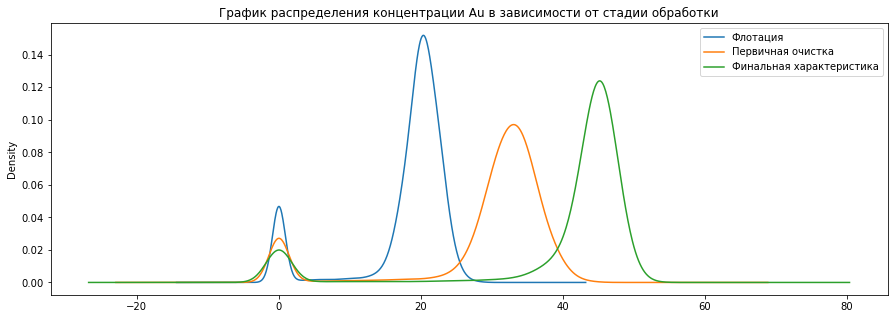

In [27]:
full.plot(y = ['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'], 
          kind='kde', figsize=(15, 5), label=['Флотация', 'Первичная очистка', 'Финальная характеристика']);
plt.title('График распределения концентрации Au в зависимости от стадии обработки');

Из данного графика видно, что концентрация Au изменяется по мере прохождения стадий технологического процесса и увеличивается от флотации до финального этапа процесса. 

Наибольшую концентрацию Au мы можем наблюдать на финальной стадии техпроцесса: среднее значение концентрации этого металла на финальной стадии лежит где-то на уровне 45. 

Напротив, наименьшая концентрация Au наблюдается на этапе флотации: среднее значение концентрации находится на уровне 20, при этом дисперсия этого значения довольно невелика относительно, например, финальной стадии. 

Из этого также следует высокая плотность среднего значения концентрации Au в данных. А вот плотность среднего значения на финальной стадии несколько ниже плотности на этапе флотации. 

Наиболее изменчива концентрация Au на стадии первичной очистки: среднее значение концентрации Au на этом этапе находится где-то в районе 30, однако плотность этого значения не так высока, как на других стадиях техпроцесса, и, как следствие - для распределения концентрации Au на этом этапе характерна более высокая относительно других стадий дисперсия. 

Также на графике можно отметить аномалию: данные о концентрации Au на всех трёх стадиях обработки имеют распределение, похожее на нормальное, однако это распределение является бимодальным: кроме мод, описанных ранее, видим ещё одну моду в точке 0.

Посмотрим, характерна ли такая особенность в данных для распределениях других металлов. 

Изучим распределение концетнтрации Ag.

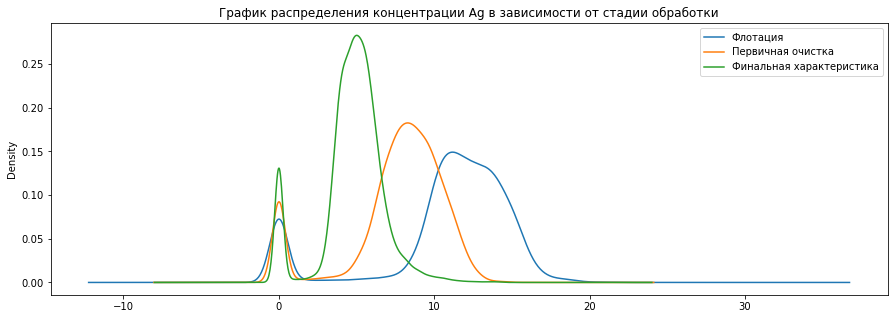

In [28]:
full.plot(y = ['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'], 
          kind='kde', figsize=(15, 5), label=['Флотация', 'Первичная очистка', 'Финальная характеристика']);
plt.title('График распределения концентрации Ag в зависимости от стадии обработки');

В целом распределение концентрации Ag напоминает распределение концентрации Au: концентрация Ag также последовательно изменяется по мере протекания техпроцесса. 

Наибольшая концентрация наблюдается на этапе флотации, при этом плотность в центре распределения самая низкая, а дисперсия - выше. 

На финальной стадии концентрация, напротив, наиболее низкая, однако в то же время плотность в центре распределения значительно выше плотности в центре распределения других стадий техпроцесса. Соответственно, финальная стадия также имеет самую низкую дисперсию.

Аномалия, выявленная при исследовании распределения концентрации Au, характерна и для распределения концентрации Ag: в целом распределение похоже на нормальное, однако оно также является бимодальным и имеет вторую моду в точке 0.

Исследуем распределение концетнтации Pb.

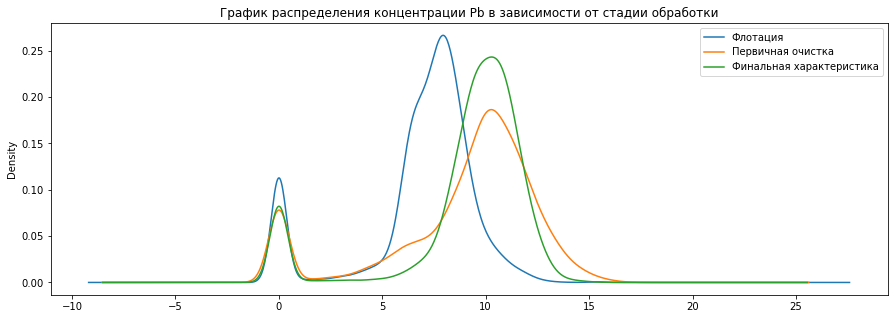

In [29]:
full.plot(y = ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'], 
          kind='kde', figsize=(15, 5), label=['Флотация', 'Первичная очистка', 'Финальная характеристика']);
plt.title('График распределения концентрации Pb в зависимости от стадии обработки');

В случае с Pb концентрация этого металла на различных стадциях техпроцесса не слишком отличается. Разница лишь в плотности распределения и величине дисперсии: на финальной стадии плотность в центре распределения выше относительно других стадий техпроцесса. 

И снова видим распределение, похожее на нормальное, однако являющееся бимодальным.

Ответ на второй вопрос подскажет, что с этом делать.

<a href='#title'>К оглавлению.</a>

<a id='2.2'></a>
## Этап 2.2. Поиск аномальных значений в суммарной концентрации всех веществ на различных этапах обработки.

На данном этапе мы попытаемся понять, есть ли аномальные значения в суммарной концентрации всех веществ на различных этапах обработки?

Для этого сначала нам нужно сформировать новые признаки, которые будут описывать суммарную концентрацию всех веществ от стадии к стадии техпроцесса. 

Для начала создадим копию полного набора данных, оставив в нём лишь нужные нам признаки. При этом избавимся от пропущенных значений.

In [30]:
total_concentrate = full[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 
'primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 
'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].copy()

total_concentrate = total_concentrate.dropna()

Далее рассчитаем необходимые признаки с суммарной концентрацией металлов.

In [31]:
total_concentrate['total_rougher'] = total_concentrate['rougher.output.concentrate_au'] + \
total_concentrate['rougher.output.concentrate_ag'] + total_concentrate['rougher.output.concentrate_pb']

total_concentrate['total_primary_cleaner'] = total_concentrate['primary_cleaner.output.concentrate_au'] + \
total_concentrate['primary_cleaner.output.concentrate_ag'] + total_concentrate['primary_cleaner.output.concentrate_pb']

total_concentrate['total_final'] = total_concentrate['final.output.concentrate_au'] + \
total_concentrate['final.output.concentrate_ag'] + total_concentrate['final.output.concentrate_pb']

Посмотрим, что получилось.

In [32]:
total_concentrate[['total_rougher', 'total_primary_cleaner', 'total_final']].head(5)

,total_rougher,total_primary_cleaner,total_final
date,,,
2016-01-15 00:00:00,38.395653,53.111627,58.137072
2016-01-15 01:00:00,38.945647,53.174338,58.699942
2016-01-15 02:00:00,38.649756,52.927464,58.927421
2016-01-15 03:00:00,38.411473,43.979185,58.714815
2016-01-15 04:00:00,38.867359,52.121146,59.065251


Видим, что мы успешно посчитали суммарную концентрацию металлов на различных стадиях техпроцесса.

Теперь нужно визуализировать их распределение. Так как это всё те же непрерывные величины, будем использовать график распределения kde.

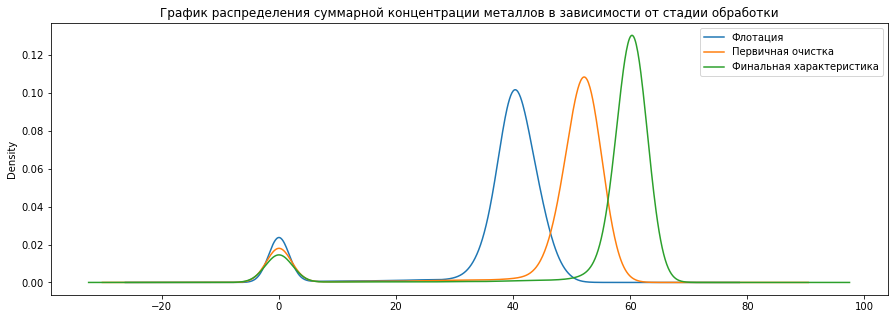

In [33]:
total_concentrate.plot(y = ['total_rougher', 'total_primary_cleaner', 'total_final'], 
          kind='kde', figsize=(15, 5), label=['Флотация', 'Первичная очистка', 'Финальная характеристика']);
plt.title('График распределения суммарной концентрации металлов в зависимости от стадии обработки');

В целом, выводы, которые мы наблюдали на этапе 2.1., справедливы и для текущего исследования: по мере движения по стадиям техпроцесса суммарная концентрация металлов и плотность их распределения в центре становится выше, а дисперсия от среднего значения - ниже. То есть вариативность концентрации уменьшается по мере обработки металлов. Однако мы видим, что распределение является бимодальным: для всех трёх стадий есть второй центр распределения в точке 0. 

На практике редко бывают случаи, когда концентрация металлов на первом этапе техпроцесса равна нулю. Вероятно, данные просто не были получены в силу тех или иных причин, однако для корректности выводов, которые будут получены в ходе дальнейших исследований, от нулевых значений в этих признаках стоит избавиться. 

Для начала избавимся от лишних признаков в наборе данных.

In [34]:
total_concentrate = total_concentrate[['total_rougher', 'total_primary_cleaner', 'total_final']]
total_concentrate.head(5)

,total_rougher,total_primary_cleaner,total_final
date,,,
2016-01-15 00:00:00,38.395653,53.111627,58.137072
2016-01-15 01:00:00,38.945647,53.174338,58.699942
2016-01-15 02:00:00,38.649756,52.927464,58.927421
2016-01-15 03:00:00,38.411473,43.979185,58.714815
2016-01-15 04:00:00,38.867359,52.121146,59.065251


In [35]:
total_concentrate = total_concentrate.query('total_rougher > 0 and total_primary_cleaner > 0 and total_final > 0')

Проверим, удалось ли избавиться от аномальных значений, равных нулю.

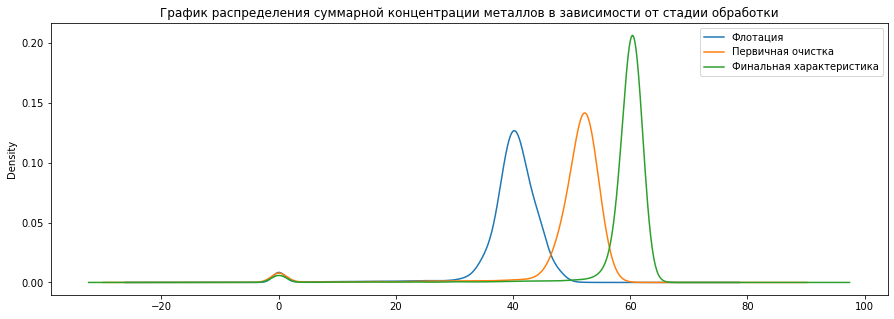

In [36]:
total_concentrate.plot(y = ['total_rougher', 'total_primary_cleaner', 'total_final'], 
          kind='kde', figsize=(15, 5), label=['Флотация', 'Первичная очистка', 'Финальная характеристика']);
plt.title('График распределения суммарной концентрации металлов в зависимости от стадии обработки');

Видим, что нам успешно удалось избавиться от аномальных значений концентрации металлов, равных нулю. На графике всё же видно некоторый всплеск в районе нуля, однако это связано с тем, что для некоторых наблюдений концентрация металлов околонулевая, но всё же не нулевая. Поэтому можем считать, что аномальные значения концентрации были отфильтрованы.

<a href='#title'>К оглавлению.</a>

<a id='2.3'></a>
## Этап 2.3. Исследование различий распределения размеров гранул сырья на обучающей и тестовой выборках.

На данном этапе исследуем различия распределения размеров гранул сырья на обучающей и тестовой выборках.

Так как мы по-прежнему имеем дело с непрерывной величиной, всё так же будем использовать гладкую оценку плотности.

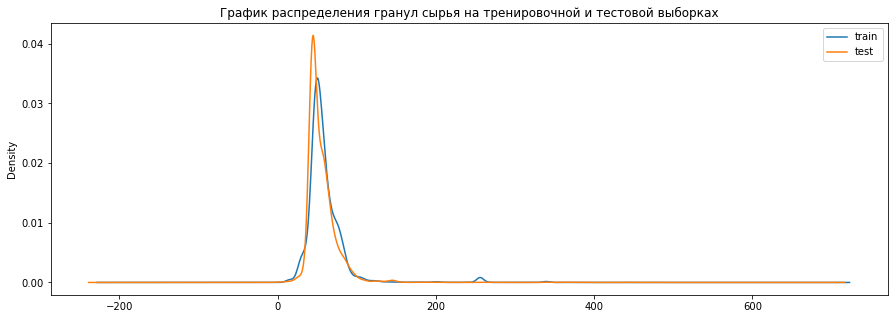

In [37]:
ax = train.plot(y='rougher.input.feed_size', kind='kde', figsize=(15, 5), label='train');
test.plot(y='rougher.input.feed_size', kind='kde', figsize=(15, 5), ax=ax, label='test');
plt.title('График распределения гранул сырья на тренировочной и тестовой выборках');
plt.show()

Из данного графика видно, что распределения размеров гранул сырья почти не отличаются в тестовой и тренировочной выборках, следовательно, модель не будет давать смещённые предсказания - данные можно использовать для моделирования.

<a href='#title'>К оглавлению.</a>

## Выводы по этапу 2.

На данном этапе был проведён анализ имеющихся данных для выявления аномальных значений и сравненительного анализа распределений концентрации металлов (в том числе суммарной) на различных этапах техпроцесса. В ходе исследования удалось получить следующие выводы:

1. Как суммарное, так и одиночное распределение концентрации металлов на различных стадиях техпроцесса демонстрирует одну и ту же тенденцию: по мере прохождения стадий техпроцесса в распределении концентрации металлов изменятся плотность распределения, а также два его основных параметра - среднее значение и дисперсия. В случае, например, с Au по мере прохождения стадий техпроцесса его концентрация увеличивается от флотации к финальной стадии. В случае с Ag ситуация обратная: концентрация этого металла небольшая на этапе флотации, но увеличивается по мере приближения к финальной стадии. В целом же суммарная концентрация всех металлов увеличивается по мере прохождения стадий техпроцесса.


2. Распределение концентрации металлов - как индивидуальная, так и суммарная - на различных стадиях техпроцесса похоже на нормальное, однако на графике гладкого распределения видна вторая мода в нулевой точке, из-за чего распределение становится бимодальным и не может считаться нормальным. Справедливо будет предположить, что в редких случаях концентрация металлов может быть нулевой на первичной стадии обработки. Поэтому аномальные значения с нулевой концентрацией металлов были удалены из набора данных.


3. Распределение размеров гранул сырья почти не отличаются в тестовой и тренировочной выборках, следовательно, модель не будет давать смещённые предсказания - данные можно использовать для моделирования.

<a href='#title'>К оглавлению.</a>

# Этап 3. Моделирование.


<a id='3.1'></a>
## 3.1. Написание функции для вычисления итоговой sMAPE.

По условиям проекта целевой метрикой качества проекта является итоговая метрика sMAPE, которая складывается из суммы sMAPE, рассчитанного на этапе флотации, и sMAPE, рассчитанного на финальном этапе, взвешенные на весовые коэффициенты в размере 0.25 и 0.75 соответственно.

Сначала напишем функцию для расчёта sMAPE. 

На вход она будет принимать вектор с истинными и предсказанными значениями, а возвращать непосредственно sMAPE.

In [38]:
def sMAPE(true, pred):
    """Функция на вход принимает вектор истинных и предсказанных значений и вычисляет метрику sMAPE"""
    return sum(np.abs(true - pred) * 2 * 100/((np.abs(true) + np.abs(pred)))) / true.shape[0]

<a href='#title'>К оглавлению.</a>

<a id='3.2'></a>
## Этап 3.2. Подбор гиперпараметорв, моделирование, проверка моделей на адекватность.

Для определения оптимальных гиперпараметров модели будем использовать метод GridSearchCV. Кросс-валидацию будем проводить на 10 фолдах, а в качестве скора будем использовать написанную нами функцию.

Чтобы у нас была возможность использовать функцию в качестве скора, нужно собрать скор, используя функцию make_scorer. Передадим greater_is_better в качестве одного из параметров функции, присвоив ему значение True. 

Это необходимо для минимизации значения метрики sMAPE, так как GridSearchCV оптимизирует функцию в сторону максимума. А чтобы найти минимум, нужно максимизировать отрицательное значение. За это отвечает параметр greater_is_better. 

In [39]:
sMAPE_loss = make_scorer(sMAPE, greater_is_better = False)

Далее создадим фичи и таргет из тренировочной и тестовой выборки. Так как нам нужно построить модели для предскзаания двух таргетов, для каждого таргета создаим свой набор фич. 

Набор данных для предсказания эффективности обогащения на этапе флотации.

In [40]:
feature_train_rougher = train.drop(['rougher.output.recovery'], axis = 1)

target_train_rougher = train['rougher.output.recovery']

feature_test_rougher = test.drop(['rougher.output.recovery'], axis = 1)

target_test_rougher = test['rougher.output.recovery']

Набор данных для предсказания эффективности обогащения на финальном этапе.

In [41]:
feature_train_final = train.drop(['final.output.recovery'], axis = 1)

target_train_final = train['final.output.recovery']

feature_test_final = test.drop(['final.output.recovery'], axis = 1)

target_test_final = test['final.output.recovery']

Данные готовы для использования. 

Приступим к тюнингу гиперпараметров.

Тюнить гиперпараметры будем для трёх моделей: RandomForestRegressor, DecisionTreeRegressor и LinearRegression. 

Так как для реализации запланированных мероприятий требуется множественная обработка большого объёма данных, целесообразно будет запараллелить вычисления. В этом нам поможет модуль parallel_backend из библиотеки sklearn.externals.joblib. 

Параллелизация вычислений позволит ускорить процедуру подбора гиперпараметров за счёт использования всех ядер компьютера вместо одного по умолчанию.

Сначала протестируем модели для предсказания эффективности обогащения чернового концентрата. Будем использовать алгоритмы RandomForestRegressor, DecisionTreeRegressor и LinearRegression, гиперпараметры будем подбирать с помощью алгоритма RandomizedSearchCV, количество итераций установим на уровне 50, кросс-валидацию проведём на 5 фолдах.

Сначала попытаемся построить модели для предсказания эффективности обогащения чернового концентрата.

Начнём с RandomForestRegressor.

In [42]:
model = RandomForestRegressor(random_state=42)
param_grid = { 
'n_estimators': [i for i in range(1, 150, 10)],
'max_depth': [i for i in range(1, 51, 10)],
'criterion': ['mse', 'mae'],
'max_features': ['auto'],
'min_samples_split': [round(i, 1) for i in np.linspace(0.1, 1.0, 10)],
'min_samples_leaf': [i for i in range(1, 15, 5)]
}

clf=RandomizedSearchCV(model, param_grid, cv=5, n_iter=50, scoring=sMAPE_loss, verbose=np.Infinity)
with parallel_backend('threading'):
    clf.fit(feature_train_rougher, target_train_rougher)

sMAPE_rougher = round(clf.best_score_, 4) * -1

print('best score RF:', sMAPE_rougher)
print('best params RF:', clf.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using 

best score RF: 14.8463
best params RF: {'n_estimators': 101, 'min_samples_split': 0.5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 21, 'criterion': 'mae'}


[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  2.7min finished


Оптимальными гиперпараметрами модели RandomForestRegressor для предсказания эффективности обогащения чернового концентрата являются: 
- n_estimators: 101;

- min_samples_split: 0.5;

- min_samples_leaf: 1;

- max_features: auto;

- max_depth: 21;

- criterion: mae.

Модель RandomForestRegressor, построенная с учётом заданных гиперпараметров, позволяет достичь метрики sMAPE для чернового концентрата на уровне 14.8463.

Протестируем модель DecisionTreeRegressor.

In [43]:
model = DecisionTreeRegressor(random_state=42)
param_grid = { 
'splitter': ['best', 'random'],
'max_depth': [i for i in range(10, 51, 10)],
'criterion': ['mse', 'mae'],
'max_features': ['auto'],
'min_samples_split': [round(i, 1) for i in np.linspace(0.1, 1.0, 10)],
'min_samples_leaf': [i for i in range(1, 16, 5)]
}

clf=RandomizedSearchCV(model, param_grid, cv=5, n_iter=50, scoring=sMAPE_loss, verbose=np.Infinity)
with parallel_backend('threading'):
    clf.fit(feature_train_rougher, target_train_rougher)

sMAPE_rougher = round(clf.best_score_, 4) * -1

print('best score DT:', sMAPE_rougher)
print('best params DT:', clf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[CV] splitter=random, min_samples_split=0.4, min_samples_leaf=6, max_features=auto, max_depth=50, criterion=mae 
[CV] splitter=random, min_samples_split=0.4, min_samples_leaf=6, max_features=auto, max_depth=50, criterion=mae 
[CV] splitter=random, min_samples_split=0.4, min_samples_leaf=6, max_features=auto, max_depth=50, criterion=mae 
[CV] splitter=random, min_samples_split=0.4, min_samples_leaf=6, max_features=auto, max_depth=50, criterion=mae 
[CV] splitter=random, min_samples_split=0.4, min_samples_leaf=6, max_features=auto, max_depth=50, criterion=mae 
[CV] splitter=random, min_samples_split=0.3, min_samples_leaf=1, max_features=auto, max_depth=30, criterion=mae 
[CV] splitter=random, min_samples_split=0.3, min_samples_leaf=1, max_features=auto, max_depth=30, criterion=mae 
[CV] splitter=random, min_samples_split=0.3, min_samples_leaf=1, 

Оптимальными гиперпараметрами модели DecisionTreeRegressor для предсказания эффективности обогащения чернового концентрата являются: 

- splitter: best;

- min_samples_split: 0.8;

- min_samples_leaf: 11;

- max_features: auto;

- max_depth: 10;

- criterion: mae.

Модель DecisionTreeRegressor, построенная с учётом заданных гиперпараметров, позволяет достичь метрики sMAPE для чернового концентрата на уровне 14.9398.

Протестируем модель LinearRegression.

In [44]:
model = LinearRegression()
param_grid = {'fit_intercept': [True, False], 
'normalize': [True, False], 
'copy_X': [True, False]
}

clf=RandomizedSearchCV(model, param_grid, cv=5, n_iter=50, scoring=sMAPE_loss, verbose=np.Infinity)
with parallel_backend('threading'):
    clf.fit(feature_train_rougher, target_train_rougher)

sMAPE_rougher = round(clf.best_score_, 4) * -1

print('best score LR:', sMAPE_rougher)
print('best params LR:', clf.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=False, fit_intercept=True, copy_X=True ................
[CV] normalize=False, fit_intercept=True, copy_X=True ................
[CV] normalize=False, fit_intercept=True, copy_X=True ................
[CV] normalize=False, fit_intercept=True, copy_X=True ................
[CV] normalize=False, fit_intercept=True, copy_X=True ................
[CV] normalize=True, fit_intercept=False, copy_X=True ................
[CV] normalize=True, fit_intercept=False, copy_X=True ................
[CV] n

Оптимальными гиперпараметрами модели LinearRegression для предсказания эффективности обогащения чернового концентрата являются: 

- normalize: True;

- fit_intercept: True;

- copy_X: True.

Модель LinearRegression, построенная с учётом заданных гиперпараметров, позволяет достичь метрики sMAPE для чернового концентрата на уровне 19.724.

Очевидно, что лучше всего эффективность обогащения чернового концентрата предсказывает модель RandomForestRegressor с гиперпараметрами:

- n_estimators: 101;

- min_samples_split: 0.5;

- min_samples_leaf: 1;

- max_features: auto;

- max_depth: 21;

- criterion: mae.

Эти параметры будем использовать при обучении итоговой модели и её тестировании на тестовых данных.

Теперь протестируем модели для предсказания эффективности обогащения финального концентрата.

Начнём с RandomForestRegressor.

In [50]:
model = RandomForestRegressor(random_state=42)
param_grid = { 
'n_estimators': [i for i in range(1, 150, 10)],
'max_depth': [i for i in range(1, 51, 10)],
'criterion': ['mse', 'mae'],
'max_features': ['auto'],
'min_samples_split': [round(i, 1) for i in np.linspace(0.1, 1.0, 10)],
'min_samples_leaf': [i for i in range(1, 15, 5)]
}

clf=RandomizedSearchCV(model, param_grid, cv=5, n_iter=50, scoring=sMAPE_loss, verbose=np.Infinity)
with parallel_backend('threading'):
    clf.fit(feature_train_final, target_train_final)

sMAPE_rougher = round(clf.best_score_, 4) * -1

print('best score RF:', sMAPE_rougher)
print('best params RF:', clf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[CV] n_estimators=121, min_samples_split=0.9, min_samples_leaf=1, max_features=auto, max_depth=1, criterion=mae 
[CV] n_estimators=121, min_samples_split=0.9, min_samples_leaf=1, max_features=auto, max_depth=1, criterion=mae 
[CV] n_estimators=121, min_samples_split=0.9, min_samples_leaf=1, max_features=auto, max_depth=1, criterion=mae 
[CV] n_estimators=121, min_samples_split=0.9, min_samples_leaf=1, max_features=auto, max_depth=1, criterion=mae 
[CV] n_estimators=121, min_samples_split=0.9, min_samples_leaf=1, max_features=auto, max_depth=1, criterion=mae 
[CV] n_estimators=111, min_samples_split=0.2, min_samples_leaf=11, max_features=auto, max_depth=31, criterion=mse 
[CV] n_estimators=111, min_samples_split=0.2, min_samples_leaf=11, max_features=auto, max_depth=31, criterion=mse 
[CV] n_estimators=111, min_samples_split=0.2, min_samples_lea

Оптимальными гиперпараметрами модели RandomForestRegressor для предсказания эффективности обогащения финального концентрата являются: 
- n_estimators: 131;

- min_samples_split: 0.4;

- min_samples_leaf: 1;

- max_features: auto;

- max_depth: 31;

- criterion: mae.

Модель RandomForestRegressor, построенная с учётом заданных гиперпараметров, позволяет достичь метрики sMAPE для финального концентрата на уровне 12.7621.

Протестируем модель DecisionTreeRegressor.

In [51]:
model = DecisionTreeRegressor(random_state=42)
param_grid = { 
'splitter': ['best', 'random'],
'max_depth': [i for i in range(10, 51, 10)],
'criterion': ['mse', 'mae'],
'max_features': ['auto'],
'min_samples_split': [round(i, 1) for i in np.linspace(0.1, 1.0, 10)],
'min_samples_leaf': [i for i in range(1, 16, 5)]
}

clf=RandomizedSearchCV(model, param_grid, cv=5, n_iter=50, scoring=sMAPE_loss, verbose=np.Infinity)
with parallel_backend('threading'):
    clf.fit(feature_train_final, target_train_final)

sMAPE_rougher = round(clf.best_score_, 4) * -1

print('best score DT:', sMAPE_rougher)
print('best params DT:', clf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[CV] splitter=random, min_samples_split=0.2, min_samples_leaf=11, max_features=auto, max_depth=30, criterion=mse 
[CV] splitter=random, min_samples_split=0.2, min_samples_leaf=11, max_features=auto, max_depth=30, criterion=mse 
[CV] splitter=random, min_samples_split=0.2, min_samples_leaf=11, max_features=auto, max_depth=30, criterion=mse 
[CV] splitter=random, min_samples_split=0.2, min_samples_leaf=11, max_features=auto, max_depth=30, criterion=mse [CV] splitter=random, min_samples_split=0.2, min_samples_leaf=11, max_features=auto, max_depth=30, criterion=mse 

[CV] splitter=best, min_samples_split=0.5, min_samples_leaf=11, max_features=auto, max_depth=10, criterion=mse [CV] splitter=best, min_samples_split=0.5, min_samples_leaf=11, max_features=auto, max_depth=10, criterion=mse 
[CV] splitter=best, min_samples_split=0.5, min_samples_leaf=11,

Оптимальными гиперпараметрами модели DecisionTreeRegressor для предсказания эффективности обогащения финального концентрата являются: 

- splitter: best;

- min_samples_split: 0.6;

- min_samples_leaf: 6;

- max_features: auto;

- max_depth: 3;

- criterion: mae.

Модель DecisionTreeRegressor, построенная с учётом заданных гиперпараметров, позволяет достичь метрики sMAPE для финального концентрата на уровне 12.8258.

Протестируем модель LinearRegression.

In [52]:
model = LinearRegression()
param_grid = {'fit_intercept': [True, False], 
'normalize': [True, False], 
'copy_X': [True, False]
}

clf=RandomizedSearchCV(model, param_grid, cv=5, n_iter=50, scoring=sMAPE_loss, verbose=np.Infinity)
with parallel_backend('threading'):
    clf.fit(feature_train_final, target_train_final)

sMAPE_rougher = round(clf.best_score_, 4) * -1

print('best score LR:', sMAPE_rougher)
print('best params LR:', clf.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=True, fit_intercept=True, copy_X=True .................
[CV] normalize=False, fit_intercept=True, copy_X=True ................[CV] normalize=False, fit_intercept=True, copy_X=True ................
[CV] normalize=False, fit_intercept=True, copy_X=True ................
[CV] normalize=False, fit_intercept=True, copy_X=True ................

[CV] normalize=False, fit_intercept=True, copy_X=True ................[CV] normalize=True, fit_intercept=False, copy_X=True ................

[CV] normalize=True, fit_intercept=False, copy_X=True ................
[CV] n

Оптимальными гиперпараметрами модели LinearRegression для предсказания эффективности обогащения финального концентрата являются: 

- normalize: True;

- fit_intercept: False;

- copy_X: True.

Модель LinearRegression, построенная с учётом заданных гиперпараметров, позволяет достичь метрики sMAPE для финального концентрата на уровне 14.6782.

Очевидно, что лучше всего эффективность обогащения финального концентрата предсказывает модель RandomForestRegressor с гиперпараметрами:

- n_estimators: 131;

- min_samples_split: 0.4;

- min_samples_leaf: 1;

- max_features: auto;

- max_depth: 31;

- criterion: mae.
Эти параметры будем использовать при обучении итоговой модели и её тестировании на тестовых данных.

Приступим к построению итоговых моделей.

Начнём с модели, предсказывающей эффективность обогащения чернового концентрата. Используем модель RandomForestRegressor с ранее определёнными гиперпараметрами.

In [83]:
model = RandomForestRegressor(random_state=42, n_estimators=101, min_samples_split=0.5, min_samples_leaf=1, 
max_features='auto', max_depth=21, criterion='mae', verbose=np.Infinity)
with parallel_backend('threading'):
    model.fit(feature_train_rougher, target_train_rougher)

predictions_rougher = model.predict(feature_test_rougher)

sMAPE_rougher = sMAPE(target_test_rougher, predictions_rougher)

print('Метрика sMAPE на черновом концентрате:', sMAPE_rougher)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
building tree 1 of 101
building tree 2 of 101
building tree 3 of 101
building tree 4 of 101
building tree 5 of 101
building tree 6 of 101
building tree 7 of 101
building tree 8 of 101
building tree 9 of 101
building tree 10 of 101
building tree 11 of 101
building tree 12 of 101
building tree 13 of 101
building tree 14 of 101
building tree 15 of 101
building tree 16 of 101
building tree 17 of 101building tree 18 of 101

building tree 19 of 101
building tree 20 of 101
building tree 21 of 101
building tree 22 of 101
building tree 23 of 101building tree 24 of 101
building tree 25 of 101
building tree 26 of 101building tree 27 of 101building tree 28 of 101


building tree 29 of 101

building tree 30 of 101building tree 31 of 101
building tree 32 of 101

building tree 33 of 101[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   48.4s

building tree 34 of 101[Parallel(n_jobs=-1)]: Done   2 tasks      | elaps

Теперь построим модель, предсказывающей эффективность обогащения финального концентрата. Используем модель RandomForestRegressor с ранее определёнными гиперпараметрами.

In [95]:
model = RandomForestRegressor(random_state=42, n_estimators=131, min_samples_split=0.4, min_samples_leaf=1, 
max_features='auto', max_depth=31, criterion='mae', verbose=np.Infinity)
with parallel_backend('threading'):
    model.fit(feature_train_final, target_train_final)

predictions_final = model.predict(feature_test_final)

sMAPE_final = sMAPE(target_test_final, predictions_final)

print('Метрика sMAPE на финальном концентрате:', sMAPE_final)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
building tree 1 of 131
building tree 2 of 131
building tree 3 of 131
building tree 4 of 131
building tree 5 of 131
building tree 6 of 131
building tree 7 of 131
building tree 8 of 131
building tree 9 of 131
building tree 10 of 131
building tree 11 of 131building tree 12 of 131

building tree 13 of 131building tree 14 of 131
building tree 15 of 131

building tree 16 of 131
building tree 17 of 131building tree 18 of 131

building tree 19 of 131
building tree 20 of 131
building tree 21 of 131building tree 22 of 131

building tree 23 of 131
building tree 24 of 131
building tree 25 of 131
building tree 26 of 131
building tree 27 of 131
building tree 28 of 131
building tree 29 of 131
building tree 30 of 131building tree 31 of 131

building tree 32 of 131
building tree 33 of 131[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.9s

building tree 34 of 131[Parallel(n_jobs=-1)]: Done   2 tasks      | elaps

Попробуем также построить модель для предсказания эффективности обогащения финального концентрата, используя гиперпараметры модели, предсказывающей эффективность обогащения чернового концентрата.

Имея sMAPE для чернового и финального концентрата, можем посчитать итоговое sMAPE, предсказание которого является основной целью проекта.

In [96]:
sMAPE_total = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final
print('Итоговое sMAPE для построенных моделей:', round(sMAPE_total, 4))

Итоговое sMAPE для построенных моделей: 11.77


Теперь нам нужно сравнить наши модели с константными моделями. В случае если мы решаем задачу регрессии, лучше всего в качестве константной модели использовать псевдомодель, которая будет во всех случаях предсказывает медианное значение нашего целевого признака.

In [100]:
predictions_rougher_const = pd.Series([train['rougher.output.recovery'].median() for i in range(len(target_test_rougher))],
    index = target_test_rougher.index)
sMAPE_rougher_const = sMAPE(target_test_rougher, predictions_rougher_const)
print('Метрика sMAPE на черновом концентрате для константной модели:', round(sMAPE_rougher_const, 4))


predictions_final_const = pd.Series([train['final.output.recovery'].median() for i in range(len(target_test_final))],
                                      index = target_test_final.index)
sMAPE_final_const = round(sMAPE(target_test_final, predictions_final_const), 4)
print('Метрика sMAPE на финальном концентрате для константной модели:', round(sMAPE_final_const, 4))


sMAPE_total_const = 0.25 * sMAPE_rougher_const + 0.75 * sMAPE_final_const


print('Итоговое sMAPE для константной модели:', round(sMAPE_total_const, 4))
print('Итоговое sMAPE для построенных моделей:', round(sMAPE_total, 4))
print('Итоговое SMAPE для построенных моделей лучше итогового sMAPE для константной модели на:', 
      round(abs(sMAPE_total_const - sMAPE_rougher_final), 4))

Метрика sMAPE на черновом концентрате для константной модели: 9.6823
Метрика sMAPE на финальном концентрате для константной модели: 12.7858
Итоговое sMAPE для константной модели: 12.0099
Итоговое sMAPE для построенных моделей: 11.77
Итоговое SMAPE для построенных моделей лучше итогового sMAPE для константной модели на: 0.7759


Видим, что построенные для предсказания эффективности обогащения чернового и финального концентратов модели обеспечивают лучшее значение sMAPE, чем константная псевдомодель, предсказывающее мединное значение во всех случаях. Следовательно, построенные модели можно считать адекватными, а результаты их работы - валидными и пригодными для работы.

Отмечу, что GridSearchCV позволил бы достичь лучших результатов, однако реализация GridSearchCV с учётом заданной сетки параметров потребовала бы 4500 итераций, что было бы затруднительно к реализации с точки зрения вычислительных мощностей. Однако в целом RandomizedSearchCV обеспечит приемлемые результаты.

<a href='#title'>К оглавлению.</a>

## Выводы по этапу 3.

На данном этапе была написана функция для расчёта итогового sMAPE, а также определены основные типы моделей, которые планировалось использовать, подобраны оптимальные гиперпараметры методом RandomizedSearchCV для определёных ранее моделей, построены и протестированы на тестовых данных модели с лучшими значениями гиперпараметров, результаты их работы были сравнены с константной псевдомоделью.

В результате удалось построить модели, обеспечивающее итоговое sMAPE в размере 11.7700 при sMAPE в размере 12.0099 на константой псевдомодели, из чего был сделан вывод об адекватности модели и валидности результатов её работы.

<a href='#title'>К оглавлению.</a>

# Итоговый вывод по проекту.

В рамках проекта требовалось подготовить прототип модели машинного обучения для «Цифры», занимающейся разработкой решения для эффективной работы промышленных предприятий.

Модель должна была предсказать коэффициент восстановления золота из золотосодержащей руды. 

В качестве базы для исследования имелись данные с параметрами добычи и очистки на различных этапах техпроцесса по получению золота из руды. 

Применение модели смогло бы оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Для достижения цели проекта был выстроен следующий план работы:

1. Подготовка данных.
2. Исследовательский анализ данных.
3. Моделирование.

Отметим выводы, полученные в ходе работы над проектом.

## Этап 1.

На данном этапе мы импортировали необходимые библиотеки, а также считали наборы данных, провели небольшой исследовательский анализ и осуществили их предобработку.

Отметим следующие выводы:

1. Тренировочная и тестовая выборки содержат информацию о различных аспектах каждого из 4 этапов техпроцесса получения золота из руды. При этом в обоих выборках присутствуют пропущенные значения и дублирующиеся объекты.


2. Ручная проверка корректности расчёта эффективности обогащения на этапе флотации показала, что расчётное и приведённое в выборке значение эффективности обогащения отличается друг от друга незначительно, о чём говорит крайне низкое значение метрики MAE. Для ручного определения эффективности обогащения была написана соответствующая функция, принимающая на вход строку в наборе данных и возвращающая значение эффективности обогащения. Применялась функция на тренировочной выборке. 


3. Количество признаков в тренировочной и тестовой выборках не соответствует друг другу: в тренировочной выборке хранится 86 признаков, в то время как в тестовой выборке хранилось лишь 52 признака. Также было сказано, что в тестовой выборке отсутствовали целевые признаки, предскзаание которых являлось целью проекта. Признаки были синхронизированы друг с другом за счёт, во-первых, удаления из тренировочной выборки признаков, которых нет в тестовой выборке, так как очевидно, что в тестовой выборке содержатся те данные, которые будут у нас в наличии при промышленной эксплуатации модели, и, во-вторых, в тестовую выборку из полного набора данных были добавлены целевые признаки.


4. В ходе предварительной обработки данных из выборок были удалены дубликаты, а пропущенные значения были заменены на схожие с соседними признаками значения, так как в соответствии с условиями задачи признаки, находящиеся рядом друг с другом по временному признаку, несильно отличаются. Для этого был использован метод fillna, его параметру method было передано значение ffill, которое подходит для обработки пропущенных значений в таких случаях.

## Этап 2.

На данном этапе был проведён анализ имеющихся данных для выявления аномальных значений и сравненительного анализа распределений концентрации металлов (в том числе суммарной) на различных этапах техпроцесса. В ходе исследования удалось получить следующие выводы:

1. Как суммарное, так и одиночное распределение концентрации металлов на различных стадиях техпроцесса демонстрирует одну и ту же тенденцию: по мере прохождения стадий техпроцесса в распределении концентрации металлов изменятся плотность распределения, а также два его основных параметра - среднее значение и дисперсия. В случае, например, с Au по мере прохождения стадий техпроцесса его концентрация увеличивается от флотации к финальной стадии. В случае с Ag ситуация обратная: концентрация этого металла небольшая на этапе флотации, но увеличивается по мере приближения к финальной стадии. В целом же суммарная концентрация всех металлов увеличивается по мере прохождения стадий техпроцесса.


2. Распределение концентрации металлов - как индивидуальная, так и суммарная - на различных стадиях техпроцесса похоже на нормальное, однако на графике гладкого распределения видна вторая мода в нулевой точке, из-за чего распределение становится бимодальным и не может считаться нормальным. Справедливо будет предположить, что в редких случаях концентрация металлов может быть нулевой на первичной стадии обработки. Поэтому аномальные значения с нулевой концентрацией металлов были удалены из набора данных.


3. Распределение размеров гранул сырья почти не отличаются в тестовой и тренировочной выборках, следовательно, модель не будет давать смещённые предсказания - данные можно использовать для моделирования.

## Этап 3.

На данном этапе была написана функция для расчёта итогового sMAPE, а также определены основные типы моделей, которые планировалось использовать, подобраны оптимальные гиперпараметры методом RandomizedSearchCV для определёных ранее моделей, построены и протестированы на тестовых данных модели с лучшими значениями гиперпараметров, результаты их работы были сравнены с константной псевдомоделью.

В результате удалось построить модели, обеспечивающее итоговое sMAPE в размере 11.7700 при sMAPE в размере 12.0099 на константой псевдомодели, из чего был сделан вывод об адекватности модели и валидности результатов её работы.

<a href='#title'>К оглавлению.</a>